In [ ]:
! pip install pmdarima

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime #ใช้สำหรับจัดการข้อมูลเกี่ยวกับวันที่และเวลา
from statsmodels.tsa.stattools import adfuller #ใช้สำหรับการวิเคราะห์ทางสถิติ โดยมีฟังก์ชันสำหรับการวิเคราะห์ Time Series ที่หลากหลาย เช่น ARIMA, Holt-Winters
#ใช้สำหรับทดสอบหน่วยราก ซึ่งเป็นการทดสอบเพื่อตรวจสอบว่าข้อมูลมีแนวโน้ม (trend) หรือฤดูกาล (seasonality) หรือไม่
from statsmodels.tsa.arima.model import ARIMA #ใช้สำหรับสร้างโมเดล ARIMA เพื่อทำนายค่าในอนาคต
from pmdarima import auto_arima # เป็นไลบรารีที่ช่วยอำนวยความสะดวกในการเลือกตัวแบบ ARIMA ที่เหมาะสมโดยอัตโนมัติ
from sklearn.metrics import mean_squared_error ,mean_absolute_error
#ใช้สำหรับประเมินประสิทธิภาพของโมเดล โดยมีตัวชี้วัดต่างๆ เช่น Mean Squared Error (MSE), Mean Absolute Error (MAE)
from statsmodels.tsa.seasonal import seasonal_decompose
# หน้าที่: ใช้สำหรับ แยกย่อย ข้อมูล Time Series ออกเป็นส่วนประกอบหลักๆ 3 ส่วน ได้แก่
# Trend: แนวโน้มการเปลี่ยนแปลงของข้อมูลในระยะยาว (เช่น การเติบโตอย่างต่อเนื่อง หรือการลดลงอย่างต่อเนื่อง)
# Seasonality: ฤดูกาล หรือรูปแบบที่เกิดขึ้นซ้ำๆ ในช่วงเวลาที่แน่นอน (เช่น ยอดขายไอศกรีมจะสูงในฤดูร้อน)
# Residual: ส่วนที่เหลือ ซึ่งเป็นส่วนที่ไม่สามารถอธิบายได้ด้วย Trend และ Seasonality
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
# เป็นกลุ่มของวิธีการที่ใช้ในการทำนายค่าในอนาคตโดยอาศัยหลักการของการให้น้ำหนักที่ลดลงเรื่อยๆ กับข้อมูลในอดีต
#ความแตกต่าง:
#SimpleExpSmoothing: เหมาะสำหรับข้อมูลที่ไม่มีแนวโน้ม (trend) และฤดูกาล (seasonality)
#ExponentialSmoothing: สามารถจัดการกับข้อมูลที่มีทั้งแนวโน้มและฤดูกาลได้ โดยมีตัวเลือกในการกำหนดชนิดของแนวโน้ม (additive หรือ multiplicative) และชนิดของฤดูกาล (additive หรือ multiplicative)
# ประโยชน์:
#ทำนายค่าในอนาคตได้อย่างรวดเร็วและง่าย
#เหมาะสำหรับข้อมูลที่มีความผันผวนสูง

In [ ]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vSs2tUlGQnffOibb2hk1XUyzkktfQFAh3_riRYu5GX9afYakQ4ZPKG1Xxjh-2imoEF13PSTiGSk_lBV/pub?output=csv',
                 parse_dates=['Order Date','Ship Date'])
df

Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
0          1  CA-2017-152156  08/11/2017  11/11/2017    Second Class   
1          2  CA-2017-152156  08/11/2017  11/11/2017    Second Class   
2          3  CA-2017-138688  12/06/2017  16/06/2017    Second Class   
3          4  US-2016-108966  11/10/2016  18/10/2016  Standard Class   
4          5  US-2016-108966  11/10/2016  18/10/2016  Standard Class   
...      ...             ...         ...         ...             ...   
9795    9796  CA-2017-125920  21/05/2017  28/05/2017  Standard Class   
9796    9797  CA-2016-128608  12/01/2016  17/01/2016  Standard Class   
9797    9798  CA-2016-128608  12/01/2016  17/01/2016  Standard Class   
9798    9799  CA-2016-128608  12/01/2016  17/01/2016  Standard Class   
9799    9800  CA-2016-128608  12/01/2016  17/01/2016  Standard Class   

     Customer ID     Customer Name    Segment        Country             City  \
0       CG-12520       Claire Gute   Consumer  United States        Henderson   
1       CG-12520       Claire Gute   Consumer  United States        Henderson   
2       DV-13045   Darrin Van Huff  Corporate  United States      Los Angeles   
3       SO-20335    Sean O'Donnell   Consumer  United States  Fort Lauderdale   
4       SO-20335    Sean O'Donnell   Consumer  United States  Fort Lauderdale   
...          ...               ...        ...            ...              ...   
9795    SH-19975     Sally Hughsby  Corporate  United States          Chicago   
9796    CS-12490  Cindy Schnelling  Corporate  United States           Toledo   
9797    CS-12490  Cindy Schnelling  Corporate  United States           Toledo   
9798    CS-12490  Cindy Schnelling  Corporate  United States           Toledo   
9799    CS-12490  Cindy Schnelling  Corporate  United States           Toledo   

           State  Postal Code   Region       Product ID         Category  \
0       Kentucky      42420.0    South  FUR-BO-10001798        Furniture   
1       Kentucky      42420.0    South  FUR-CH-10000454        Furniture   
2     California      90036.0     West  OFF-LA-10000240  Office Supplies   
3        Florida      33311.0    South  FUR-TA-10000577        Furniture   
4        Florida      33311.0    South  OFF-ST-10000760  Office Supplies   
...          ...          ...      ...              ...              ...   
9795    Illinois      60610.0  Central  OFF-BI-10003429  Office Supplies   
9796        Ohio      43615.0     East  OFF-AR-10001374  Office Supplies   
9797        Ohio      43615.0     East  TEC-PH-10004977       Technology   
9798        Ohio      43615.0     East  TEC-PH-10000912       Technology   
9799        Ohio      43615.0     East  TEC-AC-10000487       Technology   

     Sub-Category                                       Product Name     Sales  
0       Bookcases                  Bush Somerset Collection Bookcase  261.9600  
1          Chairs  Hon Deluxe Fabric Upholstered Stacking Chairs,...  731.9400  
2          Labels  Self-Adhesive Address Labels for Typewriters b...   14.6200  
3          Tables      Bretford CR4500 Series Slim Rectangular Table  957.5775  
4         Storage                     Eldon Fold 'N Roll Cart System   22.3680  
...           ...                                                ...       ...  
9795      Binders  Cardinal HOLDit! Binder Insert Strips,Extra St...    3.7980  
9796          Art           BIC Brite Liner Highlighters, Chisel Tip   10.3680  
9797       Phones                                        GE 30524EE4  235.1880  
9798       Phones           Anker 24W Portable Micro USB Car Charger   26.3760  
9799  Accessories                SanDisk Cruzer 4 GB USB Flash Drive   10.3840  

[9800 rows x 18 columns]

## อธิบายข้อมูล
- Order ID: รหัสการสั่งซื้อ เป็นรหัสเฉพาะสำหรับแต่ละออร์เดอร์
- Order Date: วันที่ทำการสั่งซื้อ
- Ship Date: วันที่จัดส่งสินค้า
- Ship Mode: วิธีการจัดส่ง เช่น Standard Class, Second Class, First Class, Same Day
- Customer ID: รหัสลูกค้า เป็นรหัสเฉพาะสำหรับแต่ละลูกค้า
- Customer Name: ชื่อลูกค้า
- Segment: กลุ่มลูกค้า เช่น Home Office, Corporate, Consumer (อาจแบ่งตามขนาดธุรกิจ หรือประเภทของลูกค้า)
- Country, City, State, Postal Code, Region: ข้อมูลที่อยู่ของลูกค้า เช่น ประเทศ, เมือง, รัฐ, รหัสไปรษณีย์, ภูมิภาค
- Product ID: รหัสสินค้า เป็นรหัสเฉพาะสำหรับแต่ละผลิตภัณฑ์
- Category: หมวดหมู่สินค้า เช่น Furniture, Office Supplies, Technology
- Sub-Category: หมวดหมู่ย่อยของสินค้า เช่น Chairs, Binders, Phones
- Product Name: ชื่อผลิตภัณฑ์
- Row ID: รหัสแถว เป็นเลขที่เรียงลำดับของแต่ละแถวในข้อมูล
- Sales: ยอดขาย


### Exploratory Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9800 non-null   int64  
 1   Order ID       9800 non-null   object 
 2   Order Date     9800 non-null   object 
 3   Ship Date      9800 non-null   object 
 4   Ship Mode      9800 non-null   object 
 5   Customer ID    9800 non-null   object 
 6   Customer Name  9800 non-null   object 
 7   Segment        9800 non-null   object 
 8   Country        9800 non-null   object 
 9   City           9800 non-null   object 
 10  State          9800 non-null   object 
 11  Postal Code    9789 non-null   float64
 12  Region         9800 non-null   object 
 13  Product ID     9800 non-null   object 
 14  Category       9800 non-null   object 
 15  Sub-Category   9800 non-null   object 
 16  Product Name   9800 non-null   object 
 17  Sales          9800 non-null   float64
dtypes: float

## ดู missing values
- Postal Cod หายไป 11 แถว

In [ ]:
df_missing = df[df['Postal Code'].isnull()]
print("\nข้อมูลที่ค่า Postal Code หายไป:")
print(df_missing)


ข้อมูลที่ค่า Postal Code หายไป:
      Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
2234    2235  CA-2018-104066  05/12/2018  10/12/2018  Standard Class   
5274    5275  CA-2016-162887  07/11/2016  09/11/2016    Second Class   
8798    8799  US-2017-150140  06/04/2017  10/04/2017  Standard Class   
9146    9147  US-2017-165505  23/01/2017  27/01/2017  Standard Class   
9147    9148  US-2017-165505  23/01/2017  27/01/2017  Standard Class   
9148    9149  US-2017-165505  23/01/2017  27/01/2017  Standard Class   
9386    9387  US-2018-127292  19/01/2018  23/01/2018  Standard Class   
9387    9388  US-2018-127292  19/01/2018  23/01/2018  Standard Class   
9388    9389  US-2018-127292  19/01/2018  23/01/2018  Standard Class   
9389    9390  US-2018-127292  19/01/2018  23/01/2018  Standard Class   
9741    9742  CA-2016-117086  08/11/2016  12/11/2016  Standard Class   

     Customer ID     Customer Name      Segment        Country        City  \
2234    QJ-19255      Qu

### ลบข้อมูลแถวที่ข้อมูลไม่ครบ

In [ ]:
df.dropna(inplace=True) #ลบข้อมูลที่ไม่ครบ

## ติดตั้ง ydata_profiling and ipywidgets
- เพื่อเอาไว้ทำ Exploratory Data

In [ ]:
!pip install ydata_profiling
!pip install ipywidgets

In [ ]:
from ydata_profiling import ProfileReport #ใช้สำหรับการวิเคราะห์ข้อมูลเบื้องต้น

In [ ]:
profile = ProfileReport(df,title='Summary Report')
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')

### Descriptive Analytics (การวิเคราะห์เชิงพรรณนา)
- จะเป็นการวิเคราะห์แบบสำรวจทั้วไปว่าข้อมูล มีอะไรบาง
- สถิติเบื้องต้นเป็นอย่างไร
- มีข้อมูลไหนที่น่าสนใจบาง

### ภาพรวมยอดขายแต่ละปี
- จากภาพรวมพบว่ายอดขายเข้ามามากในช่วงปี 2017 2018

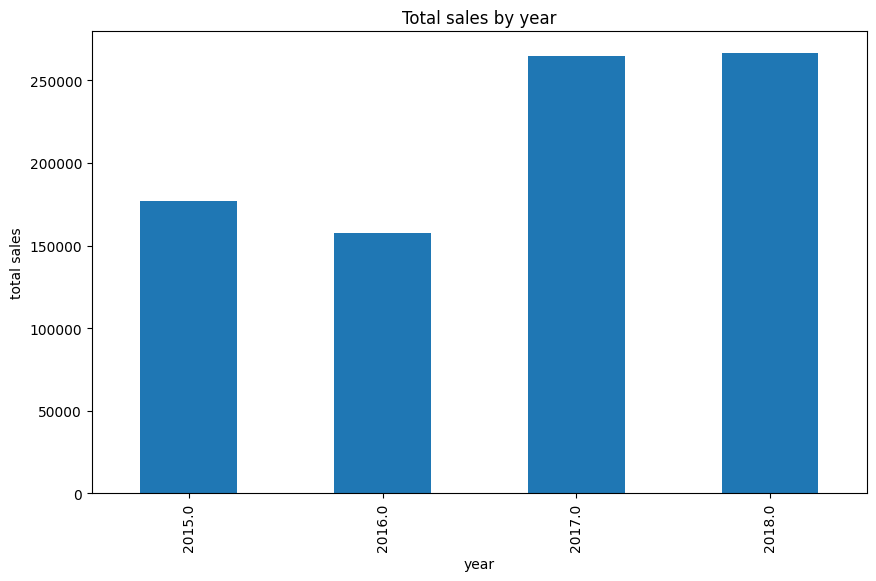

In [ ]:
yearly_sales = df.groupby(df['Order Date'].dt.year)['Sales'].sum()
plt.figure(figsize=(10, 6))
yearly_sales.plot(kind='bar')
plt.title('Total sales by year')
plt.xlabel('year')
plt.ylabel('total sales')
plt.show()

In [ ]:
pd.set_option('float_format', '{:,.2f}'.format) # ปรับตัวเลขให้เป็น ทศนิยม 2 ตำแหน่ง

## ค่าสถิติเบื้องต้น columns Sales
- จากข้อมูลสถิติเบื้องต้น
- ค่าเฉลี่ยยอดขายทั้งหมดอยู่ที่ 230.12
- ค่า Median 54.38
- ส่วนเบี่ยงเบนอยู่ที่ 625.30
- ยอดขายสูงสุดอยู่ที่ 22.638


In [ ]:
df.describe()

Row ID                     Order Date  Postal Code     Sales
count 9,789.00                           3955     9,789.00  9,789.00
mean  4,896.71  2017-03-14 18:03:54.841972224    55,273.32    230.12
min       1.00            2015-01-02 00:00:00     1,040.00      0.44
25%   2,449.00            2016-04-05 00:00:00    23,223.00     17.25
50%   4,896.00            2017-05-02 00:00:00    58,103.00     54.38
75%   7,344.00            2018-03-07 00:00:00    90,008.00    210.39
max   9,800.00            2018-12-11 00:00:00    99,301.00 22,638.48
std   2,827.49                            NaN    32,041.22    625.30

## ข้อมูลนี้เป็นข้อมูลค่าปลีก
- อยากทราบว่า ข้อมูลนี้มีสินค้าประเภทไหนบาง
- จากข้อมูลพบว่ามีสินค้าอยู่ 3 ประเภทใหญ่ๆ คือ
- Furniture , Office Supplies , Technology

In [ ]:
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
#df['year'] = df['Order Date'].dt.year.fillna(0).astype(int)

## plot boxplot
- สินค้าทั้ง 3 อย่างของบริษัทนั้น
- สินค้าประเภท เทคโนโลยีนั้นมียอดขายมากที่สุดจาก 3 สินค้า
- สินค้าเทคโนโลยีมียอดขายมากที่สุด
- outliner จะอยู่ที่ Category Technology เพราะมีค่าที่สูงมากกว่าปรติ

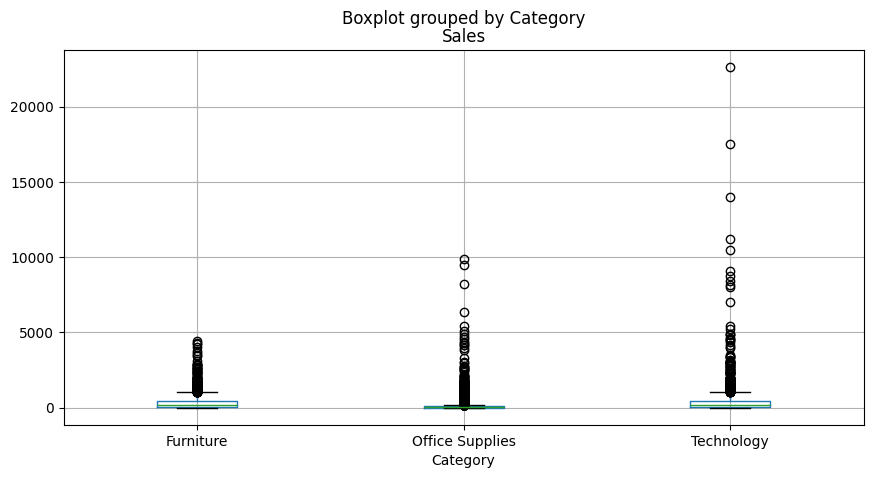

In [ ]:
df.boxplot(column='Sales',by='Category',figsize=(10,5));

### สรุปภาพรวมของข้อมูลเบื้องต้น
- ข้อมูลที่มีข้อมูลโดยรวมประมาณ 3 ปี คือ  2015 - 2018
- จากกราฟบ่งบอกว่า ยอดขาย 4 ปี ปีที่มียอดขายมาก คือ 2017 - 2018
- มีสินค้าที่ขายอยู่ 3 Category คือ Furniture Office Supplies Technology
- ยอดขายต่อคนสูงที่สุด คือ 22,638.48
- ค่าเฉลี่ยอยู่ที่ 230.12
- ค่า Median 54.38

----

## Diagnostic Analytics (การวิเคราะห์เชิงวินิจฉัย)
- เป็นการวิเคาะห์แบบเจาะลึกลงไปว่า ทำไมมันถึงเกิดขึ้น?
- ทำไมยอดขายถึงสูงขึ้นในปี 2017 และ 2018

### ลูกค้าที่มียอดชื้อสูงสุด The top 5 spending customer
- รายชื่อลูกค้าที่มีการจ่ายเงินมากที่สุด ถือเป็นลูกค้าชั้นดีที่ควรเก็บรักษาไว้
- จากการดูข้อมูลพบว่า ลูกค้าที่อยู่ใน Segment Home Office คือ
- Sean Miller และ Tom Ashbrook เป็นลูกที่อยู่ Segment Home Office
- ที่มียอดค่าใช้จ่ายกับเราสูงติด top 5

<Axes: title={'center': 'Top 5 spending customer'}, ylabel='Customer Name'>

Customer Name  Segment    
Sean Miller    Home Office   22,638.48
Tamara Chand   Corporate     17,499.95
Raymond Buch   Consumer      13,999.96
Tom Ashbrook   Home Office   11,199.97
Hunter Lopez   Consumer      10,499.97
Name: Sales, dtype: float64

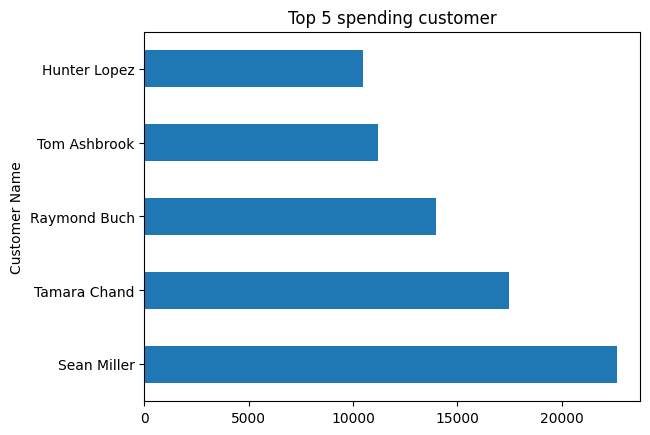

In [ ]:
display(df.sort_values(by='Sales',ascending=False)[0:5].groupby('Customer Name')['Sales'].sum().sort_values(ascending=False).plot(kind='barh',title='Top 5 spending customer'),
        df.sort_values(by='Sales',ascending=False)[0:5].groupby(['Customer Name','Segment'])['Sales'].sum().sort_values(ascending=False))

### ลูกค้า Segment ไหนที่ในภาพรวมแล้วใช้จ่ายกับเรามากที่สุด
- ลูกค้า Consumer ใช้จ่ายกับเรามากที่สุด
- ลูกค้า Corporate เป็นกลุ่มที่ใช้จ่ายรองลงมาเป็นอันดับ 2
- กลุ่มลูกค้า Home office ใช้จ่ายกับเราน้อยที่สุด

<Axes: title={'center': 'Top 5 spending customer'}, ylabel='Segment'>

Segment
Consumer      1,146,708.15
Corporate       682,211.83
Home Office     423,687.43
Name: Sales, dtype: float64

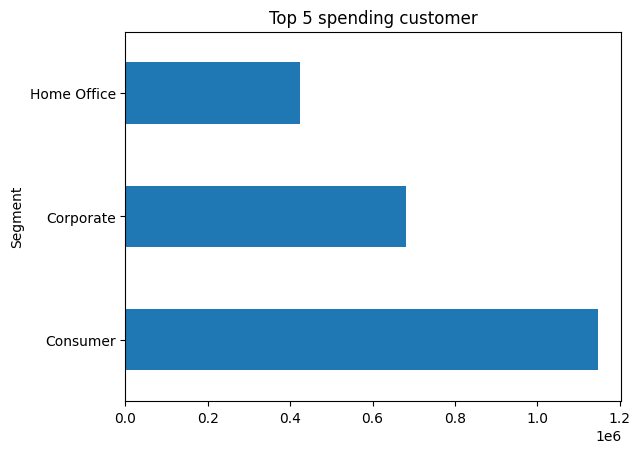

In [ ]:
display(df.sort_values(by='Sales',ascending=False).groupby('Segment')['Sales'].sum().sort_values(ascending=False).plot(kind='barh',title='Top 5 spending customer'),
        df.groupby('Segment')['Sales'].sum().sort_values(ascending=False))

## สินค้า Category ไหนเป็นที่นิยมของลูกค้าในภาพรวม
- สินค้าที่เกี่ยวกับ Technology เป็นสินค้าที่ได้รับความนิยมสูงสุด
- โดยมียอดขายสูงที่สุด 825,856.11

<Axes: title={'center': 'Top category'}, xlabel='Category'>

Sales
Category                  
Technology      825,856.11
Furniture       723,538.48
Office Supplies 703,212.82

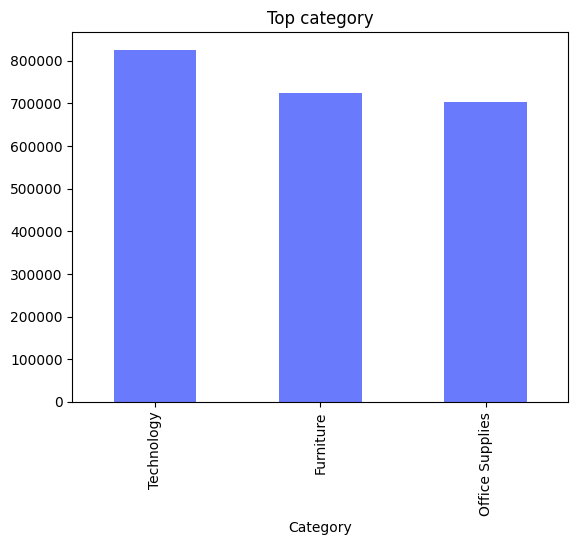

In [ ]:
display(df.groupby('Category')['Sales'].sum().sort_values(ascending=False).plot(kind='bar',color='#6a7afc',title='Top category'),
        pd.pivot_table(df,index='Category',values='Sales',aggfunc='sum').sort_values(by='Sales',ascending=False))

## สินค้าที่เกี่ยวกับ เทคโนโลยี สินค้าไหนบางเป็นสินค้าที่ขายดีที่สุด
- สินค้าที่เกี่ยวโทรศัพท์เป็นสินค้าที่ขายดีที่สุด
- ในภาพรวมสินค้าที่เกี่ยวกับเทคโนโลยี ค่อนข้างจะเป็นที่นิยมของลูกค้า
- โดยสินค้าที่เป็นที่นิยมมากที่สุดคือ Phones มียอดขายถึง 326,487.70

Sub-Category
Phones        326,487.70
Machines      189,238.63
Accessories   163,881.69
Copiers       146,248.09
Name: Sales, dtype: float64

<Axes: title={'center': 'Technology sales'}, ylabel='Sub-Category'>

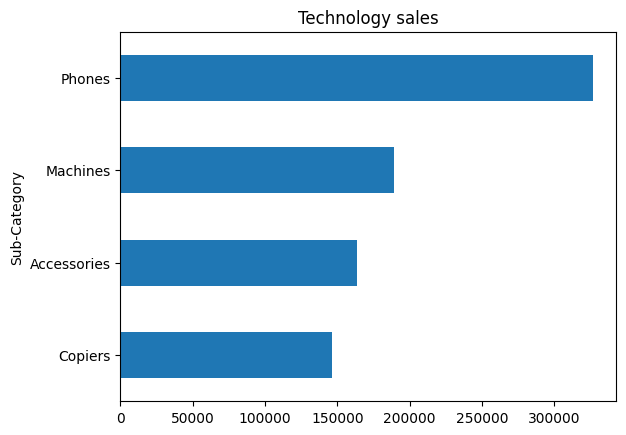

In [ ]:
display(df[df['Category']=='Technology'].groupby('Sub-Category')['Sales'].sum().sort_values(ascending=False),
df[df['Category']=='Technology'].groupby('Sub-Category')['Sales'].sum().sort_values(ascending=True).plot(kind='barh',title='Technology sales'));

### ลูกค้า Segment ไหน นิยมชื้อสินค้า เทคโนโลยีมากที่สุด
- ลูกค้า Consumer เป็นลูกค้าที่จ่ายเงินมากที่สุดใน กลุ่มสินค้าเทคโนโลยี
- ถ้าดูจากยอดรวม 401,011.66 จากยอดรวมทั้งหมด 825,856.11 ถือว่าได้เยอะมากประมาณ ครึ่งนึงของ กลุ่มสินค้า Technology
- กลุ่ม Home Office ก็นิยมชื้อสินค้าเทคโนโลยีจริง แต่ก็ยังน้อยกว่า กลุ่ม Consumer

In [ ]:
pd.pivot_table(df[df['Category']=='Technology'],index='Segment',values='Sales',aggfunc='sum',margins=True)

Sales
Segment               
Consumer    401,011.66
Corporate   243,736.83
Home Office 181,107.62
All         825,856.11

## รายชื่อสินค้าที่ กลุ่มลูกค้า Consumer นิยมชื้อมากที่สุด
- ถ้าดูจากรายการสินค้าแลัว กลุ่มลูกค้า Cousumer ก็นิยมชื้อสินค้าที่หลากหลายอยู่เหมือนกัน
- สิ่งที่สังเกตุเห็น คือ ลูกค้า กลุ่ม Cousumer อาจจะนิยม สินค้า Office Supplies มากว่า
- (เพราะใน list รายการติด Category Office Supplies	มากที่สุด)
- แต่ที่เราเห็น ว่าสินค้าเกี่ยวเทคโนโลยีขึ้นมาสูง เป็นเพราะสินค้า Technology นั้นมีราคาแพง ทำให้เกิดยอดขายที่สูง
### สรุป ข้อมูล
- กลุ่มลูกค้า Consumer ไม่ได้นิยมชื้อสินค้า Technology แต่เป็นสินค้า Category ประเภท Office Supplies มากกว่า
- แต่สิ่งที่ทำให้บริษัทมียอดขายเพิ่ม คือสินค้าประเภท Techonlogy ที่อาจจะเป็นเพียงแค่กระแส ในปี 2017 - 2018
- เพราะสินค้าที่มีความนิยมอาจจะไม่ใช่สินค้าราคาสูง อาจจะเป็นสินค้านิยมใช้ในชีวิตประจำวัน เช่น Office Supplies
- สรุปสินค้าที่เป็นที่นิยมของกลุ่มลูกค้า คือ Office Supplies ไม่ใช้ Technology
- สินค้า Technology เป็นเพียงสินค้าราคาสูง อาจจะเป็นกระแสได้ความนิยม แต่อาจจะยังไม่ใช่สินต้ายอดนิยม Consumer

In [ ]:
df[df['Segment']=='Consumer'].groupby(['Segment','Category','Sub-Category'])['Sales'].sum().sort_values(ascending=False)

Segment   Category         Sub-Category
Consumer  Furniture        Chairs         170,458.90
          Technology       Phones         169,230.63
          Office Supplies  Binders        117,091.91
          Furniture        Tables          99,847.82
          Office Supplies  Storage         98,783.23
          Technology       Accessories     85,699.07
                           Machines        79,542.82
          Furniture        Bookcases       67,949.40
          Technology       Copiers         66,539.13
          Office Supplies  Appliances      51,824.29
          Furniture        Furnishings     48,724.95
          Office Supplies  Paper           35,507.37
                           Supplies        25,531.09
                           Art             14,062.26
                           Envelopes        7,629.56
                           Labels           6,610.73
                           Fasteners        1,675.00
Name: Sales, dtype: float64

## จากข้อมูลเราอยากทราบว่า สินค้าเกี่ยวกับเทคโนโลยีนั้นยอดขายมาจากที่ไหนมากที่สุด
- จากข้อมูลพบว่ายอดขายมากจากทาง ทิศตะวันออก มากที่สุด
- รองลงมาก็มากจาก ตะวันตก
- คาดว่ากลุ่มลูกค้าน่าจะเป็นคนทาง ทิศตะวันออก และ ตะวันตก ที่มาใช้บริการสินค้า
- สิ่งที่เราไม่รู้ คือสินค้าที่ขายดีที่ ทิศตะวันออก ตะวันตก อาจจะไม่ใช้ phons ก็ได้

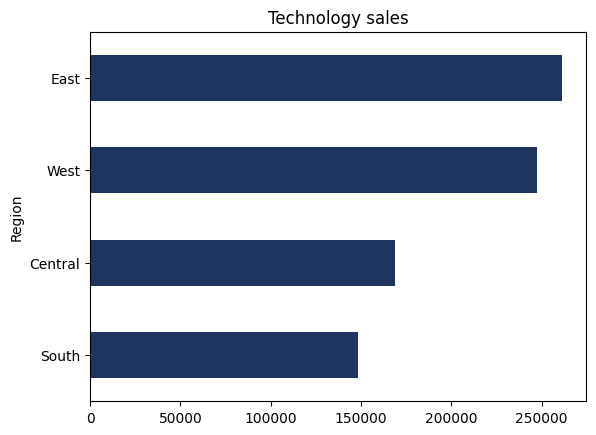

In [ ]:
df[df['Category']=='Technology'].groupby('Region')['Sales'].sum().sort_values(ascending=True).plot(kind='barh',title='Technology sales',color='#1e3461');

## จากข้อมูลพบว่า สินค้าประเภท เทคโนโลยีนั้นเป็นสินค้าขายดี อันดับ 1 ของทุกภาค
- จากข้อมูลที่ได้พบว่า ทิศตะวันออก ตะวันตกขายสินค้าเทคโนโลยีได้มากที่สุด
- ส่วนลูกค้าภาคกลาง และ ภาคใต้ ยังอยู่ในระดับที่น้อยกว่า ทิศตะวันออก ตะวันตก ดังนั้นเราควรจะมาทำการตลาด เพื่อเพิ่มยอดขายให้กับ Central และ South 2 ภาคนี้จะดีกว่า
- จากที่พบ ภาค West East เป็นภาคที่สามารถขายสินค้าได้ทั้ง 3 หมวดได้ ค่อนข้างจะเยอะ เพราะยอดขายของทั้ง 3 หมวดนั้นมียอดขายที่ใกล้เคียงกันมาก

In [ ]:
display(df[df['Region']=='East'].groupby('Category')['Sales'].sum().sort_values(ascending=False).to_frame('The most popular product category in the East region'),
        df[df['Region']=='West'].groupby('Category')['Sales'].sum().sort_values(ascending=False).to_frame('The most popular product category in the West region'),
        df[df['Region']=='Central'].groupby('Category')['Sales'].sum().sort_values(ascending=False).to_frame('The most popular product category in the Central region'),
        df[df['Region']=='South'].groupby('Category')['Sales'].sum().sort_values(ascending=False).to_frame('The most popular product category in the South region'))

The most popular product category in the East region
Category                                                             
Technology                                              261,516.77   
Furniture                                               201,341.29   
Office Supplies                                         197,731.30

The most popular product category in the West region
Category                                                             
Technology                                              247,404.93   
Furniture                                               245,348.25   
Office Supplies                                         217,466.51

The most popular product category in the Central region
Category                                                                
Technology                                              168,739.21      
Office Supplies                                         163,590.24      
Furniture                                               160,317.46

The most popular product category in the South region
Category                                                              
Technology                                              148,195.21    
Office Supplies                                         124,424.77    
Furniture                                               116,531.48

## สินค้าขายดีอย่าง phones ยอดขายมากจาก รัฐไหนและเมืองไหน มากที่สุด
- จากข้อมูลพบว่า สินค้าเทคโนโลยีนั้นลูกค้าของเราจะอยู่ที่รัฐ California เป็นหลัก
- ที่นิยมชื้อของที่เป็นเทคโนโลยีไป โดนสินค้าที่เป็นที่นิยมมากที่สุดก็คือ Phones

## สินค้าขายดีเช่น phones มากจากรัฐใหญ่ๆ 4 รัฐ
- new york
- California (ติด top มาก 2 เมือง คือ los Angeles และ San Francisco) ถ้าเอาทั้ง 2 เมืองมารวมจะได้มากกว่า new york เพราะฉะนั้น California มียอดขายที่เข้ามามากที่สุด โดยเฉพาะ สินค้าเทคโนโลยี
- pennsylvania
- llinois

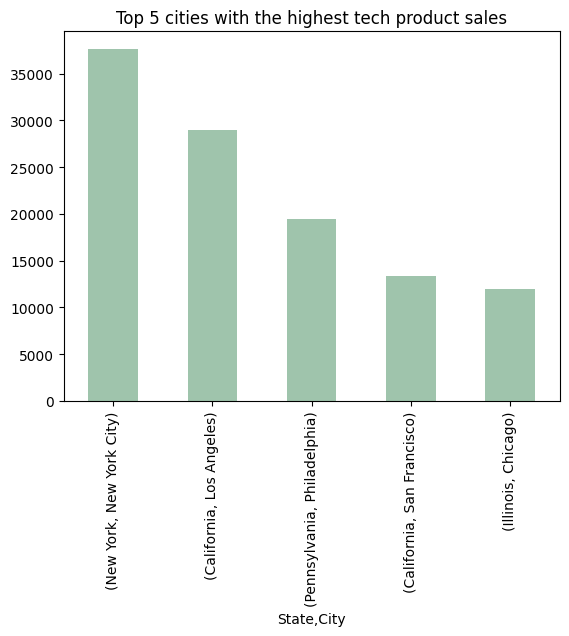

In [ ]:
df[df['Sub-Category']=='Phones'].groupby(['State','City'])['Sales'].sum().sort_values(ascending=False)[0:5]\
.plot(kind='bar',title='Top 5 cities with the highest tech product sales',color='#9fc4ac');

----

## จุดเด่นของสินค้าเทคโนโลยี
- สินค้ามีการพัฒนาอัปเดทตลอด
- เป็นสินค้าที่มีราคาสูง หรือต่ำ ขึ้นอยู่กับฮีห้อ หรือผู้ผลิต
- เป็นสินค้าที่ทุกคนขาดไม่ได้ในปัจจุบัน
## จุดอ่อนของสินค้าเทคโนโลยี
- เป็นสินค้าที่มาไว้ไปไว้ ราคามีความ ผันผวนสูง
- เป็นสินค้าที่ตกรุ่นเร็ว
- เป็นสินค้าที่สามารถหาแทนกันได้ตลอด
## สรุปการวิเคราะห์ข้อมูล
- สินค้าที่ขายดี เช่น สินค้า Technology หรือ Phons นั้นส่วนมากมากจากลูกค้า Consumer ที่มากจาก
- new york
- California (los Angeles และ San Francisco)
- pennsylvania
- llinois
- โดยเฉพาะ California ที่ยอดขายมากที่สุดในสินค้าหมวด Technology

---

## ยอดสะสมของสินค้าเทคโนโลยี
- จาการวิเคราะห์ข้อมูล ยอดรวมสะสมของสินค้า Technology (ทุกอย่างในหมวด Technology)
- พบว่าสินค้า Technology นั้นขายดีมากจริง เพราะมียอดรวมสะสมที่พุ่งสูงค่อนข้างเร็วมาก
- ถ้าดูจากกราฟ จะพบว่าการวิ่งของยอดขายสูงขึ้นอย่างต่อเนื่องและค่อนข้างจะเร็วมาก
- ถ้าดูจากกราฟและข้อมูลประกอบพบว่า ถ้าเรามองสินค้าโดยภาพ นั้นแสดงให้เห็นว่า
- แค่เฉพาะสินค้า เทคโนโลยี อย่างเดี่ยว จะใช้เวลา 332 วัน ในการขายสินค้า (ไม่ถึง 1 ปี)
- ตามความคิดเห็นมองว่าใช้เวลาไม่นานมากเท่าไร ในการขายสินค้านี้
- มียอดสะสม 52,979,030.91

In [ ]:
df_Sales_Technology = df[df['Category']=='Technology']
df_Sales_Technology.sort_values(['Region', 'Order Date'], inplace=True)
df_Sales_Technology.reset_index(drop=True, inplace=True)
df_Sales_Technology=df_Sales_Technology.groupby('Order Date').sum()[['Sales']]
df_Sales_Technology=df_Sales_Technology.cumsum()
df_Sales_Technology.reset_index(inplace=True)

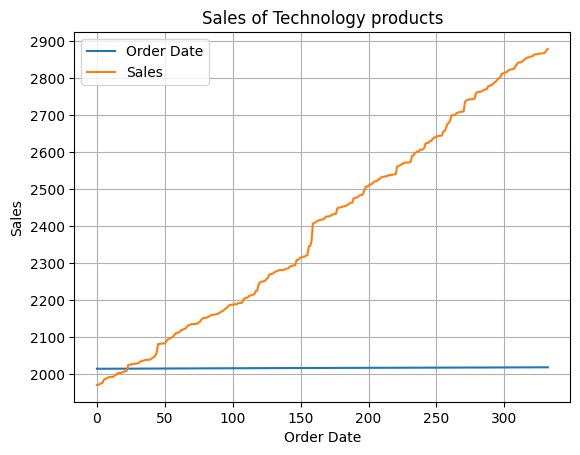

In [ ]:
df_Sales_Technology.plot(kind='line')
plt.title('Sales of Technology products')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.grid(True)
plt.axis('tight')
plt.show();

In [ ]:
df_Sales_Technology['Daily_Sales'] = df_Sales_Technology.groupby('Order Date')['Sales'].transform('sum')
df_Sales_Technology['Cumulative_Sales'] = df_Sales_Technology['Daily_Sales'].cumsum()
df_Sales_Technology.tail(5)

Order Date      Sales  Daily_Sales  Cumulative_Sales
328 2018-12-05 327,926.65   327,926.65     51,658,785.58
329 2018-12-06 328,062.55   328,062.55     51,986,848.13
330 2018-12-08 328,780.11   328,780.11     52,315,628.25
331 2018-12-10 331,058.35   331,058.35     52,646,686.60
332 2018-12-11 332,344.31   332,344.31     52,979,030.91

## เราจะมาหายอดสะสมของสินค้า Office Supplies
- จากข้อมูลยอดรวมสะสมของการขายสินค้า Office Supplies
- พบว่า สินค้ามีแนวโน้มที่สูงขึ้นอย่างต่อเนื่อง เช่นเดี่ยวกับ Technology
- สิ่งที่เห็นคือ ระยะเวลาในการขาย นั้นใช้เวลานานกว่า สินค้า Technology
- สินค้า Technology ใช้เวลา 322 วัน สินค้า Office Supplies ใช้เวลาถึง 443 วัน (ประมาณ 1 ปี กับอีก 5 เดือน โดยประมาณ)
- สินค้า Office Supplies เป็นสินค้าที่ขายได้ แต่อาจจะช้าหน่อย
- ถ้าต้องการให้สินค้าขายได้เร็วมากขึ้นต้องทำการตลาด เกี่ยวสินค้า Office Supplies
- เพื่อเร่งยอดขาย และลดสินค้าที่เสี่ยงต่อการคางสต็อก
- มียอดสะสม 50,628,415.57


In [ ]:
df_Sales_Office_Supplies = df[df['Category']=='Office Supplies']
df_Sales_Office_Supplies.sort_values(['Region', 'Order Date'], inplace=True)
df_Sales_Office_Supplies.reset_index(drop=True, inplace=True)
df_Sales_Office_Supplies=df_Sales_Office_Supplies.groupby('Order Date').sum()[['Sales']]
df_Sales_Office_Supplies=df_Sales_Office_Supplies.cumsum()
df_Sales_Office_Supplies.reset_index(inplace=True)

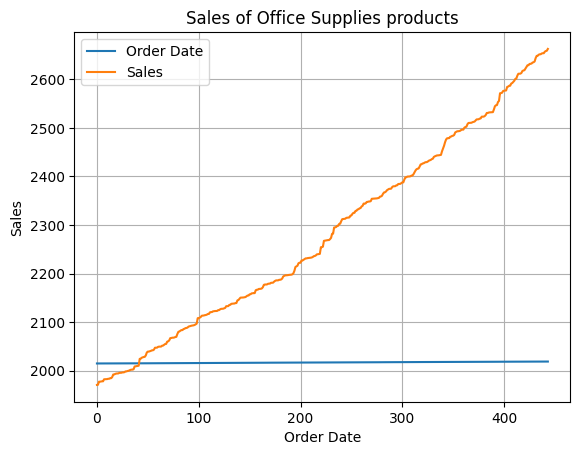

In [ ]:
df_Sales_Office_Supplies.plot(kind='line')
plt.title('Sales of Office Supplies products')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.grid(True)
plt.axis('tight')
plt.show();

In [ ]:
df_Sales_Office_Supplies['Daily_Sales'] = df_Sales_Office_Supplies.groupby('Order Date')['Sales'].transform('sum')
df_Sales_Office_Supplies['Cumulative_Sales'] = df_Sales_Office_Supplies['Daily_Sales'].cumsum()
df_Sales_Office_Supplies.tail(5)

Order Date      Sales  Daily_Sales  Cumulative_Sales
439 2018-12-07 249,733.32   249,733.32     49,621,647.15
440 2018-12-08 250,874.02   250,874.02     49,872,521.17
441 2018-12-09 251,357.21   251,357.21     50,123,878.37
442 2018-12-10 251,581.04   251,581.04     50,375,459.41
443 2018-12-11 252,956.16   252,956.16     50,628,415.57

### หายอดขายสะสมของสินค้า Furniture
- จากข้อมูลพบว่าสินค้า Furniture ก็มีการขายสินค้าที่ดีเช่นกัน
- มียอดสะสม 46,682,542.02
- ใช้เวลาทั้งหมด 335 วัน หรือ ไม่ถึง 1 ปี
- ถือเป็นสินค้าที่ขายได้ ค่อยข้างจะเร็วเหมือนกัน

In [ ]:
df_Sales_Furniture = df[df['Category']=='Furniture']
df_Sales_Furniture.sort_values(['Region', 'Order Date'], inplace=True)
df_Sales_Furniture.reset_index(drop=True, inplace=True)
df_Sales_Furniture=df_Sales_Furniture.groupby('Order Date').sum()[['Sales']]
df_Sales_Furniture=df_Sales_Furniture.cumsum()
df_Sales_Furniture.reset_index(inplace=True)

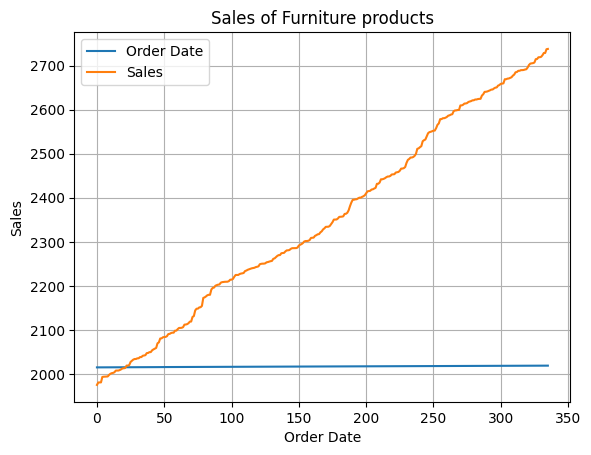

In [ ]:
df_Sales_Furniture.plot(kind='line')
plt.title('Sales of Furniture products')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.grid(True)
plt.axis('tight')
plt.show();

In [ ]:
df_Sales_Furniture['Daily_Sales'] = df_Sales_Furniture.groupby('Order Date')['Sales'].transform('sum')
df_Sales_Furniture['Cumulative_Sales'] = df_Sales_Furniture['Daily_Sales'].cumsum()
df_Sales_Furniture.tail(5)

Order Date      Sales  Daily_Sales  Cumulative_Sales
331 2018-12-06 275,225.96   275,225.96     45,567,776.86
332 2018-12-08 277,060.78   277,060.78     45,844,837.64
333 2018-12-09 277,069.14   277,069.14     46,121,906.78
334 2018-12-10 280,192.47   280,192.47     46,402,099.25
335 2018-12-11 280,442.77   280,442.77     46,682,542.02

In [ ]:
filtered_df_2015 = df[df['Order Date'].dt.year == 2015]

Category
Furniture         63,658.75
Technology        60,570.93
Office Supplies   52,756.90
Name: Sales, dtype: float64

<Axes: title={'center': 'Top category 2015'}, xlabel='Category'>

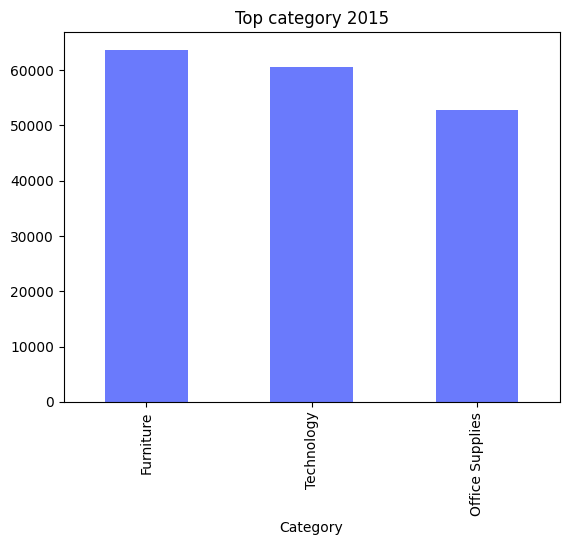

In [ ]:
display(filtered_df_2015.groupby('Category')['Sales'].sum().sort_values(ascending=False),
        filtered_df_2015.groupby('Category')['Sales'].sum().sort_values(ascending=False).plot(kind='bar',color='#6a7afc',title='Top category 2015'))

In [ ]:
filtered_df_2016 = df[df['Order Date'].dt.year == 2016]

Category
Technology        58,121.89
Furniture         54,985.93
Office Supplies   44,340.94
Name: Sales, dtype: float64

<Axes: title={'center': 'Top category 2016'}, xlabel='Category'>

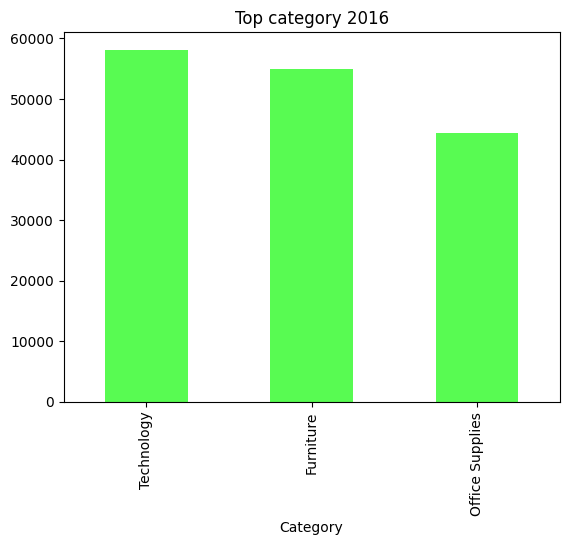

In [ ]:
display(filtered_df_2016.groupby('Category')['Sales'].sum().sort_values(ascending=False),
        filtered_df_2016.groupby('Category')['Sales'].sum().sort_values(ascending=False).plot(kind='bar',color='#58fb52',title='Top category 2016'))

### ข้อมูลวิเคราะห์สินค้ายอดสะสม
- สินค้าที่ทำยอดขายได้มากที่สุดและเร็วที่สุด  
1.   Technology
2.   Furniture
3.   Office Supplies
---
### สรุปการวิเคราะห์ข้อมูล Diagnostic Analytics (การวิเคราะห์เชิงวินิจฉัย)
1. สินค้าที่ขายดีและมียอดขายสูงสุดคือสินค้า Technology นั้นจริง
2. สินค้า Office Supplies เป็นสินค้าที่ขายได้ช้าที่สุด ต้องระวังเรื่องของการค้างสต็อก
3. กลุ่มลูกค้าที่ใช้จ่างเงินกับบริษัทมากที่สุด คือ กลุ่ม Segment Consumer (แต่ไม่ได้นิยมสินค้า Technology นิยมสินค้า Office Supplies มากกว่า)
4. สินค้า Technology อาจจะไม่ใช้สินค้ายอดนิยม แต่เพราะเป็นสินค้าราคาแพง ยอดขายเลยสูงกว่า Category อื่นๆ
5. ยอดขาย สินค้าโดยเฉพาะ Technology มากจาก  West East มากที่สุด
6. ส่วนยอดขายจาก Central และ South ควรวางแผนการตลาด เพื่อเพิ่มยอดขาย
7. รัฐที่ขายสินค้าได้มากที่สุด คือ California (ติด top มาก 2 เมือง คือ los Angeles และ San Francisco) โดยเฉพาะสินค้า Technology ประเภท Phons นั้นขายดีมาก
8. ในปี 2015 สินค้า Furniture เป็นสินค้าที่ทำยอดขายได้มากที่สุด
9. ในปี 2016 สินค้า Technology เริ่มที่จะเป็นสินค้าที่ทำยอดขายได้มากที่สุด ตั้งแต่ 2016 ถึง 2018 ทั้งๆที่ภาพรวมปี 2016 มียอดขายน้อยกว่า ปี 2015



-----

### Predictive Analytics (การวิเคราะห์เชิงคาดการณ์)
- ทำอะไร: ทำนายสิ่งที่จะเกิดขึ้นในอนาคต
- คำถาม: จะเกิดอะไรขึ้น? ยอดขายในเดือนหน้าจะเป็นเท่าไร ?


----

### การวิเคราะห์นี้จะเป็นการวิเคราะห์ยอดขายโดยที่ไม่แบ่งตัวสินค้า
- เน้นดูภาพรวม และการจำลองว่าในอนาคตจะเกิดอะไรขึ้นบางในแบบจำลองนี้
- เรามาดูกันก่อนว่าแต่ละเดือนขายอยู่ที่ประมาณเท่าไร ?

In [ ]:
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='ME'))['Sales'].sum()
monthly_sales[0:12]

Order Date
2015-01-31   19,546.16
2015-02-28   11,678.99
2015-03-31    6,716.04
2015-04-30   12,455.48
2015-05-31   15,165.05
2015-06-30   11,884.17
2015-07-31   10,075.74
2015-08-31   26,797.76
2015-09-30   17,158.93
2015-10-31   10,112.64
2015-11-30   18,349.76
2015-12-31   17,045.84
Name: Sales, dtype: float64

## ถ้าดูจากกราฟการกระจายตัวของข้อมูล
- พบว่าข้อมูลมีการกระจายตัวที่อยู่ไปทางแบ้ขวาเป็นส่วนมาก

Text(0.5, 1.0, 'Distribution of Monthly Sales')

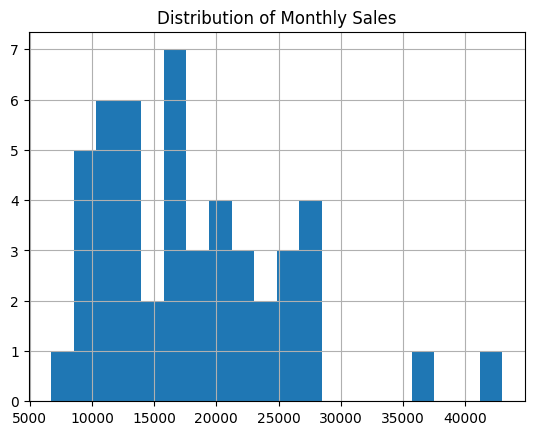

In [ ]:
monthly_sales.hist(bins=20)
plt.title('Distribution of Monthly Sales')

18036.317575

<Axes: title={'center': 'Boxplot of Monthly Sales'}>

Text(0.5, 1.0, 'Boxplot of Monthly Sales')

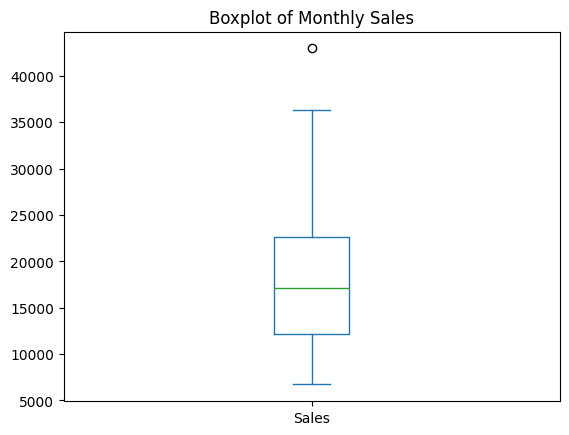

In [ ]:
display(monthly_sales.mean(),
        monthly_sales.plot(kind='box'),
        plt.title('Boxplot of Monthly Sales'))

### เนื่องจากใน Diagnostic Analytics (การวิเคราะห์เชิงวินิจฉัย)
- เราพบว่ามีลูกค้ารายใหญ่ที่จ่ายเงินให้กับบริษัท
- ในทางธุรกิจเราควรที่จะเก็บลูกค้าส่วนนี้ไปวิเคราะห์ต่อเพื่อหาสิ่งที่ต่อยอดต่อไป

### code เก็บลูกค้า ที่เป็น outliner
- เพื่อนำไปวิเคาะห์ต่อยอด

In [ ]:
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1

# กำหนดขอบเขตบน
upper_bound = Q3 + 1.5 * IQR

# กรองข้อมูลที่มากกว่า Upper Bound
outliers = df[df['Sales'] > upper_bound]

# แสดงผลลัพธ์
outliers

Row ID        Order ID Order Date   Ship Date       Ship Mode  \
1          2  CA-2017-152156 2017-08-11  11/11/2017    Second Class   
3          4  US-2016-108966 2016-11-10  18/10/2016  Standard Class   
7          8  CA-2015-115812 2015-09-06  14/06/2015  Standard Class   
10        11  CA-2015-115812 2015-09-06  14/06/2015  Standard Class   
11        12  CA-2015-115812 2015-09-06  14/06/2015  Standard Class   
...      ...             ...        ...         ...             ...   
9759    9760  CA-2017-146913        NaT  05/11/2017  Standard Class   
9774    9775  CA-2015-169019        NaT  30/07/2015  Standard Class   
9781    9782  CA-2017-153178        NaT  18/09/2017  Standard Class   
9787    9788  CA-2018-144491        NaT  01/04/2018  Standard Class   
9788    9789  CA-2018-144491        NaT  01/04/2018  Standard Class   

     Customer ID    Customer Name    Segment        Country             City  \
1       CG-12520      Claire Gute   Consumer  United States        Henderson   
3       SO-20335   Sean O'Donnell   Consumer  United States  Fort Lauderdale   
7       BH-11710  Brosina Hoffman   Consumer  United States      Los Angeles   
10      BH-11710  Brosina Hoffman   Consumer  United States      Los Angeles   
11      BH-11710  Brosina Hoffman   Consumer  United States      Los Angeles   
...          ...              ...        ...            ...              ...   
9759    SF-20965  Sylvia Foulston  Corporate  United States    San Francisco   
9774    LF-17185      Luke Foster   Consumer  United States      San Antonio   
9781    CL-12565      Clay Ludtke   Consumer  United States       Long Beach   
9787    CJ-12010  Caroline Jumper   Consumer  United States          Houston   
9788    CJ-12010  Caroline Jumper   Consumer  United States          Houston   

           State  Postal Code   Region       Product ID         Category  \
1       Kentucky    42,420.00    South  FUR-CH-10000454        Furniture   
3        Florida    33,311.00    South  FUR-TA-10000577        Furniture   
7     California    90,032.00     West  TEC-PH-10002275       Technology   
10    California    90,032.00     West  FUR-TA-10001539        Furniture   
11    California    90,032.00     West  TEC-PH-10002033       Technology   
...          ...          ...      ...              ...              ...   
9759  California    94,109.00     West  FUR-CH-10001854        Furniture   
9774       Texas    78,207.00  Central  OFF-BI-10004995  Office Supplies   
9781    New York    11,561.00     East  OFF-BI-10004390  Office Supplies   
9787       Texas    77,070.00  Central  FUR-BO-10001811        Furniture   
9788       Texas    77,070.00  Central  FUR-CH-10004063        Furniture   

     Sub-Category                                       Product Name    Sales  
1          Chairs  Hon Deluxe Fabric Upholstered Stacking Chairs,...   731.94  
3          Tables      Bretford CR4500 Series Slim Rectangular Table   957.58  
7          Phones                     Mitel 5320 IP Phone VoIP phone   907.15  
10         Tables           Chromcraft Rectangular Conference Tables 1,706.18  
11         Phones      Konftel 250 Conference phone - Charcoal black   911.42  
...           ...                                                ...      ...  
9759       Chairs  Office Star - Professional Matrix Back Chair w... 1,403.92  
9774      Binders          GBC DocuBind P400 Electric Binding System 2,177.58  
9781      Binders            GBC DocuBind 200 Manual Binding Machine   673.57  
9787    Bookcases  Atlantic Metals Mobile 5-Shelf Bookcases, Cust... 1,023.33  
9788       Chairs            Global Deluxe High-Back Manager's Chair   600.56  

[1141 rows x 18 columns]

In [ ]:
outliers.to_csv('outliers_sales.csv',index=False) #เก็บค่าลูกค้าที่มีค่าใช้จ่ายที่สูงผิดปรติ

### ลบค่า outline
- คำนวณ IQR

In [ ]:
# คำนวณ Q1 และ Q3
Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)

# คำนวณ IQR
IQR = Q3 - Q1

# กำหนดช่วงของค่าที่ยอมรับได้
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# ลบค่าที่อยู่นอกช่วง
df_filtered = df[(df['Sales'] >= lower_bound) & (df['Sales'] <= upper_bound)]

## วิเคราะห์ กราฟ
- จากกราฟที่แสดง สามารถสรุปแนวโน้มของยอดขายได้ดังนี้ \
แนวโน้มโดยรวม: ยอดขายโดยรวมมีแนวโน้มเพิ่มขึ้นอย่างต่อเนื่อง โดยเฉพาะในช่วงหลังๆ ของกราฟ จะเห็นได้ชัดว่ายอดขายพุ่งสูงขึ้นอย่างมาก
- ความผันผวน: แม้ว่าจะมีแนวโน้มขาขึ้น แต่ยอดขายก็มีความผันผวนค่อนข้างสูงในแต่ละเดือน อาจเกิดจากปัจจัยต่างๆ เช่น ฤดูกาล โปรโมชั่น หรือปัจจัยภายนอกอื่นๆ ที่ส่งผลต่อการตัดสินใจซื้อของลูกค้า
- ปัจจัยที่อาจส่งผลต่อยอดขาย:

ปัจจัยภายใน:
การเปิดตัวสินค้าใหม่: การเปิดตัวสินค้าใหม่ที่ได้รับความนิยมอาจส่งผลให้ยอดขายเพิ่มขึ้นอย่างรวดเร็ว
การทำโปรโมชั่น: การจัดโปรโมชั่นลดราคา หรือแคมเปญส่งเสริมการขายต่างๆ สามารถกระตุ้นยอดขายได้
การปรับปรุงคุณภาพสินค้า: การปรับปรุงคุณภาพสินค้าให้ดีขึ้น อาจดึงดูดลูกค้าใหม่ๆ และเพิ่มยอดขายได้
- ปัจจัยภายนอก:
สภาวะเศรษฐกิจ: สภาวะเศรษฐกิจที่ขยายตัวมักส่งผลดีต่อยอดขาย แต่หากเศรษฐกิจชะลอตัว ยอดขายก็อาจลดลงตามไปด้วย
ฤดูกาล: ผลิตภัณฑ์บางประเภทยอดขายอาจผันผวนตามฤดูกาล เช่น สินค้าฤดูร้อน ฤดูหนาว
คู่แข่ง: การแข่งขันจากคู่แข่งอาจส่งผลต่อส่วนแบ่งทางการตลาดและยอดขายของบริษัท
เหตุการณ์ที่ไม่คาดคิด: เหตุการณ์ที่ไม่คาดคิด เช่น ภัยธรรมชาติ วิกฤตเศรษฐกิจ หรือการเปลี่ยนแปลงทางการเมือง อาจส่งผลกระทบต่อยอดขายอย่างรุนแรง

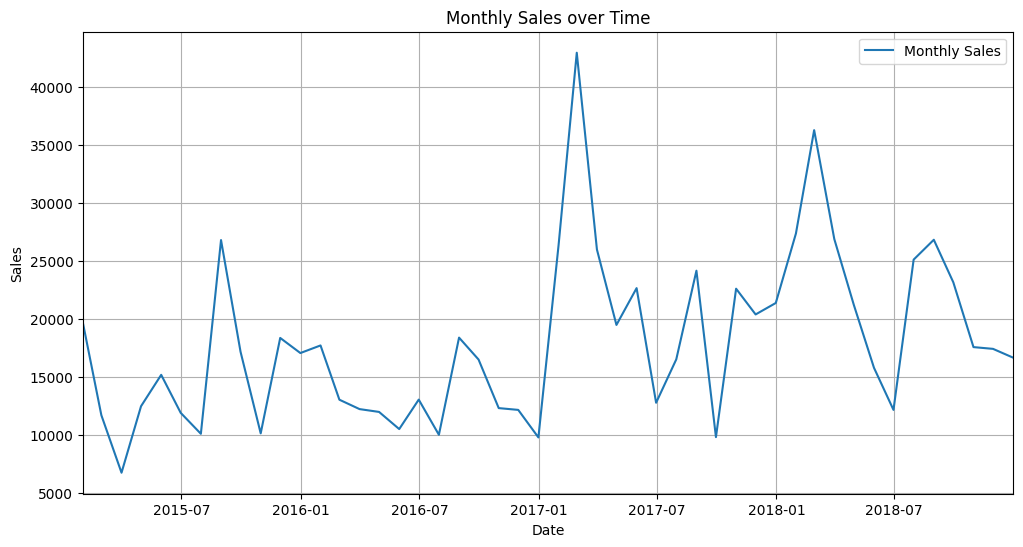

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_sales, label='Monthly Sales')
plt.title('Monthly Sales over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.legend()
plt.autoscale(axis='x',tight=True)
plt.show()

### อธิบาย code
- seasonal_decompose: เป็นฟังก์ชันจากไลบรารี Statsmodels ที่ใช้สำหรับวิเคราะห์การสลายตัวของอนุกรมเวลา
- model='additive': กำหนดให้การสลายตัวเป็นแบบบวก (Additive) ซึ่งหมายความว่าค่าของอนุกรมเวลาใดๆ สามารถเขียนได้เป็นผลรวมของ Trend (แนวโน้ม), Seasonal (ฤดูกาล), และ Residual (ส่วนที่เหลือ)
- decomposition: ตัวแปรที่เก็บผลลัพธ์ของการวิเคราะห์ ซึ่งประกอบด้วย Trend, Seasonal, และ Residual
### การตีความหมายของผลลัพธ์
- Observed: กราฟแสดงข้อมูลยอดขายจริง
- Trend: แสดงแนวโน้มโดยรวมของยอดขาย (เพิ่มขึ้น ลดลง หรือคงที่)
- Seasonal: แสดงรูปแบบตามฤดูกาล (เช่น ยอดขายสูงในช่วงเทศกาล)
- Residual: แสดงส่วนที่เหลือหลังจากลบ Trend และ Seasonal ออกไป ซึ่งอาจเป็น Noise หรือรูปแบบอื่นๆ ที่ไม่ได้อธิบายโดย Trend และ Seasonal
### วิเคราะห์จาก กราฟที่แสดงออกมา
- Observed: คือยอดขายจริงที่เห็นทั้งหมด มีแนวโน้มสูงขึ้นเป็นช่วงๆ
- Trend: แนวโน้มโดยรวมของยอดขาย ว่าโดยเฉลี่ยแล้ว \
ยอดขายมีแนวโน้มเพิ่มขึ้น
- Seasonal:คือส่วนที่เกิดจากปัจจัยตามฤดูกาลจากกราฟพบว่าช่วงที่ขายดีจะอยู่ในช่วงต้นปีของทุกปี
- Residual อาจจะเป็นค่า Error ของข้อมูล
### ประโยชน์ของการวิเคราะห์
- เข้าใจปัจจัยที่ส่งผลต่อยอดขาย: สามารถวิเคราะห์ได้ว่าปัจจัยใดมีผลต่อยอดขายมากที่สุด เช่น ฤดูกาล เศรษฐกิจ หรือปัจจัยอื่นๆ
- พยากรณ์ยอดขาย: สามารถนำผลลัพธ์ของการวิเคราะห์ไปใช้ในการพยากรณ์ยอดขายในอนาคตได้
- ปรับปรุงกลยุทธ์ทางธุรกิจ: สามารถนำข้อมูลที่ได้ไปปรับปรุงกลยุทธ์ทางธุรกิจ เช่น การวางแผนการผลิต การจัดสรรงบประมาณ หรือการทำโปรโมชั่น

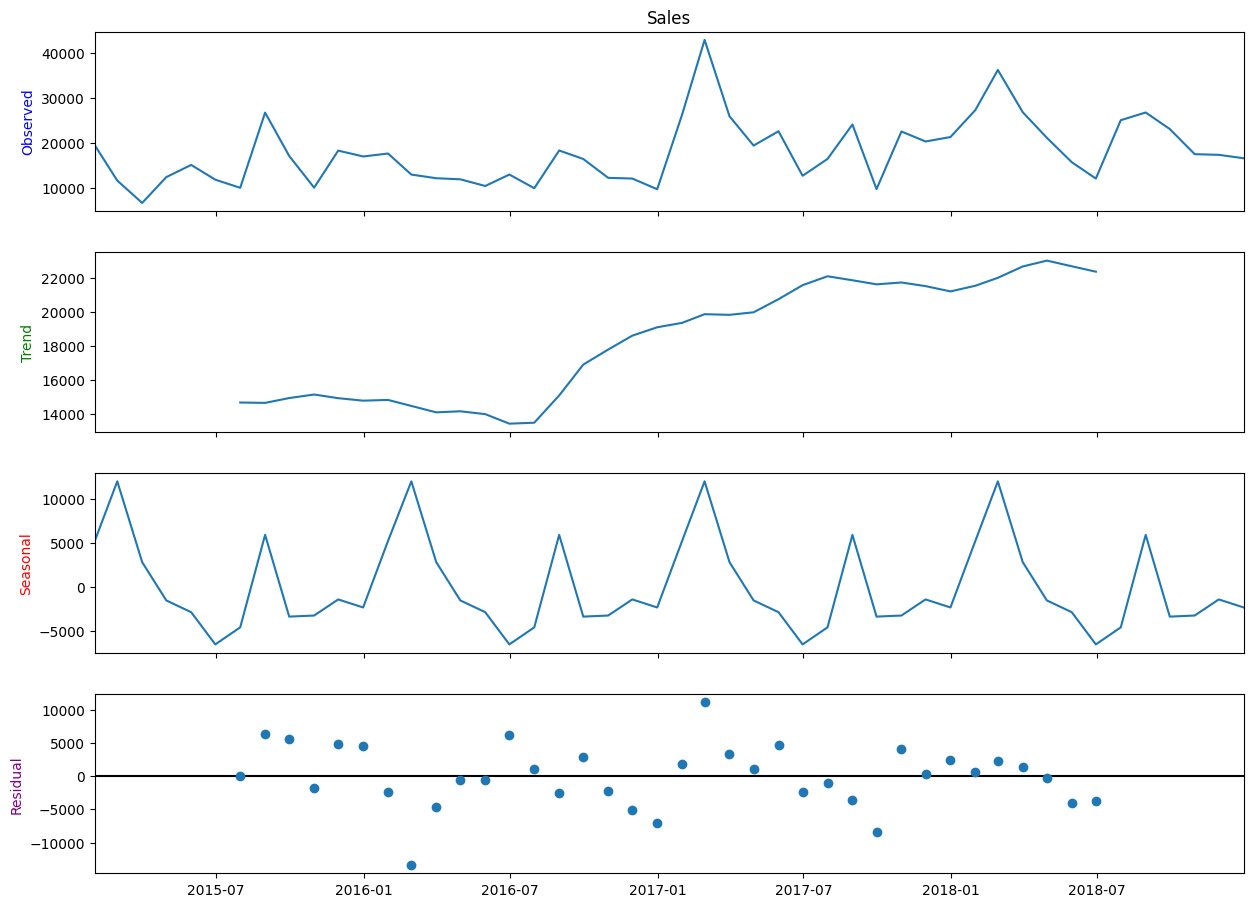

In [ ]:
decomposition = seasonal_decompose(monthly_sales, model='additive')
fig = decomposition.plot()
fig.set_size_inches(14, 10)
ax = fig.axes
ax[0].set_ylabel('Observed', color='blue')
ax[1].set_ylabel('Trend', color='green')
ax[2].set_ylabel('Seasonal', color='red')
ax[3].set_ylabel('Residual', color='purple')
plt.show()

## ตรวจสอบว่าข้อมูลอนุกรมเวลา (Time Series) นั้นมีความนิ่ง (Stationary) หรือไม่
- ทำไมต้องตรวจสอบความนิ่ง?
ความนิ่ง (Stationarity) หมายถึง คุณสมบัติของข้อมูลที่ค่าเฉลี่ย ค่าความแปรปรวน และโครงสร้างของความสัมพันธ์ระหว่างข้อมูลไม่เปลี่ยนแปลงตามเวลา
- การตรวจสอบความนิ่งมีความสำคัญ เพราะหากข้อมูลไม่นิ่ง การวิเคราะห์และพยากรณ์ด้วยวิธีการทางสถิติทั่วไปอาจให้ผลลัพธ์ที่ไม่ถูกต้อง
- ผลสรุปข้อมูลค่อนข้างนิ่ง (ความคิดเห็นส่วนตัว)

In [ ]:
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print('Augmented Dickey-Fuller Test Results:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    return result[1] < 0.05

is_stationary = check_stationarity(monthly_sales)
print(f"\nTime Series is {'stationary' if is_stationary else 'non-stationary'}")

Augmented Dickey-Fuller Test Results:
ADF Statistic: -4.100443318519394
p-value: 0.0009668916228377
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064

Time Series is stationary


### อธิบายผลลัพธ์การทดสอบ ADF
- ผลการทดสอบบอกว่า ข้อมูลของคุณมีความนิ่ง (stationary)
- หมายความว่า ข้อมูลมีลักษณะที่ค่อนข้างคงที่ ไม่เปลี่ยนแปลงไปตามเวลา เช่น ค่าเฉลี่ย ค่าความแปรปรวน และโครงสร้างของข้อมูล จะคงที่อยู่ตลอดไป
### วิธีการอ่านผลการ วิเคราะห์ผลการทดสอบ
- ADF Statistic: ค่านี้เป็นค่าที่ได้จากการคำนวณ ซึ่งจะเปรียบเทียบกับค่าวิกฤต
- p-value: ค่านี้บอกความน่าจะเป็นที่เราจะได้ผลลัพธ์แบบนี้โดยบังเอิญ ถ้าค่า p-value น้อยกว่าระดับนัยสำคัญ (เช่น 0.05) แสดงว่าเราปฏิเสธสมมติฐานว่าง (null hypothesis) ซึ่งหมายความว่าข้อมูลมีความนิ่ง
- Critical Values: ค่าเหล่านี้เป็นค่าอ้างอิงที่ใช้เปรียบเทียบกับ ADF Statistic เพื่อตัดสินใจ
- ในกรณีนี้

- p-value (0.0009) น้อยกว่า 0.05 อย่างมาก แสดงว่าเราปฏิเสธสมมติฐานว่างได้
- ADF Statistic (-4.416) น้อยกว่าค่าวิกฤตทั้งหมด (1%, 5%, 10%) แสดงว่าข้อมูลมีความนิ่งอย่างชัดเจน
- สรุป:
จากผลการทดสอบ ADF ข้อมูลยอดขายรายเดือนของข้อมูลมีความนิ่ง สามารถนำข้อมูลนี้ไปวิเคราะห์หรือพยากรณ์ได้


----

### แบบจำลอง ARIMA (AutoRegressive Integrated Moving Average)
- เพื่อทำนายค่าของข้อมูลอนุกรมเวลา (Time Series) โดยเฉพาะข้อมูลยอดขายรายเดือน (monthly_sales) ในที่นี้ ฟังก์ชัน auto_arima จะช่วยค้นหาค่าพารามิเตอร์ที่ดีที่สุดสำหรับแบบจำลอง ARIMA ให้เราโดยอัตโนมัติ
### อธิบายพารามิเตอร์ต่างๆ

- auto_arima(monthly_sales): เรียกใช้ฟังก์ชัน auto_arima โดยใส่ข้อมูลยอดขายรายเดือนเข้าไป
- start_p=0, start_q=0: กำหนดค่าเริ่มต้นของพารามิเตอร์ p และ q
- max_p=5, max_q=5: กำหนดค่าสูงสุดของพารามิเตอร์ p และ q ที่จะให้ฟังก์ชันลองหาค่าที่ดีที่สุด
- m=12: กำหนดจำนวนช่วงเวลาในหนึ่งรอบ (ในที่นี้คือ 12 เดือน เพราะเป็นข้อมูลรายเดือน)
- seasonal=True: บอกให้ฟังก์ชันพิจารณาปัจจัยตามฤดูกาลด้วย
- d=None: ให้ฟังก์ชันหาค่า d ที่เหมาะสมที่สุดโดยอัตโนมัติ
- trace=True: แสดงขั้นตอนการค้นหาค่าพารามิเตอร์
- error_action='ignore', suppress_warnings=True: ปิดการแสดงข้อผิดพลาดและคำเตือน
- stepwise=True: ใช้ขั้นตอนการค้นหาแบบ stepwise เพื่อเพิ่มประสิทธิภาพ
### พารามิเตอร์ p, d, q คืออะไร?

- p: แทนจำนวนค่าล่าสุดที่นำมาใช้ในการพยากรณ์ค่าปัจจุบัน (AutoRegression)
- d: แทนจำนวนครั้งที่ต้องทำ differencing เพื่อทำให้ข้อมูลนิ่ง (Integrated)
- q: แทนจำนวนค่า error ในอดีตที่นำมาใช้ในการพยากรณ์ค่าปัจจุบัน (Moving Average)

In [ ]:
auto_model = auto_arima(monthly_sales,
                        start_p=0,start_q=0,
                        max_p=5, max_q=5,
                        m=12,
                        seasonal=True,
                        d=None,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=977.082, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=977.191, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=975.681, Time=0.06 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=975.205, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=976.061, Time=0.05 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=976.764, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=977.021, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=inf, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 1.191 seconds


### อธิบายผลลัพธ์การค้นหาแบบจำลอง ARIMA
- ARIMA(p,d,q)(P,D,Q)[m]: นี่คือชื่อของแบบจำลองที่โปรแกรมกำลังทดลอง ตัวเลขต่างๆ ที่อยู่ในวงเล็บหมายถึงค่าพารามิเตอร์ของแบบจำลอง
- AIC: คือค่าที่ใช้ประเมินว่าแบบจำลองนั้นดีแค่ไหน ค่า AIC ที่ต่ำกว่า หมายถึงแบบจำลองนั้นดีกว่า (ยิ่งต่ำยิ่งดี)
- Time: คือเวลาที่ใช้ในการคำนวณแบบจำลองนั้น
- Best model: บรรทัดนี้จะบอกว่า แบบจำลองไหนดีที่สุด โดยดูจากค่า AIC ที่ต่ำที่สุด\
คำตอบ คือ  ARIMA(0,1,0)(1,0,0)[12]\
Total fit time: 2.893 seconds\
# คำแนะนำเพิ่มเติม

อย่าเพิ่งเชื่อผลลัพธ์ 100%: ควรตรวจสอบผลลัพธ์เพิ่มเติม เช่น เปรียบเทียบกับข้อมูลจริง หรือใช้เทคนิคอื่นๆในการตรวจสอบ
(ปรึกษาผู้เชี่ยวชาญดีกว่า)

### แบบจำลอง ARIMA เพื่อทำนายข้อมูลอนุกรมเวลา (Time Series)
-  โดยใช้พารามิเตอร์ที่ได้จากการค้นหาที่ดีที่สุดในขั้นตอนก่อนหน้า (ซึ่งก็คือผลลัพธ์ที่เราได้วิเคราะห์ไปแล้ว)
- ARIMA: เป็นคำสั่งสร้างแบบจำลอง ARIMA
- monthly_sales: คือข้อมูลที่เราต้องการนำมาทำนาย (ในที่นี้คือยอดขายรายเดือน)
- order=auto_model.order: กำหนดค่า p, d, q ของส่วนที่ไม่ใช่ฤดูกาล (non-seasonal part) ให้ตรงกับค่าที่ได้จากการค้นหาที่ดีที่สุดในขั้นตอนก่อนหน้า
- seasonal_order=auto_model.seasonal_order: กำหนดค่า P, D, Q ของส่วนที่เป็นฤดูกาล (seasonal part) ให้ตรงกับค่าที่ได้จากการค้นหาที่ดีที่สุดในขั้นตอนก่อนหน้า
---
- เอาผลลัพธ์จากการค้นหาแบบจำลองที่ดีที่สุด (ที่ได้จากโค้ดชุดก่อนหน้า) มาสร้างเป็นแบบจำลอง ARIMA ที่สมบูรณ์ เพื่อเตรียมพร้อมสำหรับการนำไปใช้ทำนายค่าในอนาคต

In [ ]:
model = ARIMA(monthly_sales,
              order=auto_model.order,
              seasonal_order=auto_model.seasonal_order)
results = model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


### อธิบายโค้ดทำนายข้อมูลอนุกรมเวลา
- จำลอง ARIMA ที่เราสร้างเสร็จเรียบร้อยแล้วไปใช้ ทำนายค่าในอนาคต
- forecast_periods = 12: บรรทัดนี้กำหนดว่าเราต้องการทำนายค่าในอนาคตออกไปกี่ช่วงเวลา ในที่นี้คือ 12 ช่วงเวลา ซึ่งอาจหมายถึง 12 เดือนก็ได้
- forecast = results.get_forecast(steps=forecast_periods): บรรทัดนี้ใช้คำสั่ง .get_forecast() เพื่อทำนายค่าในอนาคตตามจำนวนช่วงเวลาที่กำหนดไว้ในบรรทัดแรก ผลลัพธ์ของการทำนายจะถูกเก็บไว้ในตัวแปร forecast
- mean_forecast = forecast.predicted_mean: บรรทัดนี้ดึงเอาค่าทำนายเฉลี่ยของแต่ละช่วงเวลาออกมาเก็บไว้ในตัวแปร mean_forecast\
---
### ทำนายค่าของข้อมูลอนุกรมเวลาในอีก 12 ช่วงเวลาข้างหน้า และเก็บค่าทำนายเฉลี่ยของแต่ละช่วงเวลาไว้ เพื่อที่เราจะนำไปวิเคราะห์หรือนำเสนอต่อไป

In [ ]:
forecast_periods = 12
forecast = results.get_forecast(steps=forecast_periods)
mean_forecast = forecast.predicted_mean

# ช่วงความเชื่อมั่น (Confidence Interval)
- ช่วงความเชื่อมั่น ของค่าทำนายที่เราได้จากแบบจำลอง ARIMA ค่ะ ช่วงความเชื่อมั่นนี้จะบอกเราว่าค่าจริงในอนาคตมีโอกาสที่จะอยู่ระหว่างค่าใดและค่าใด ด้วยความน่าจะเป็นที่กำหนดไว้
---
- conf_int_95 = forecast.conf_int(alpha=0.05): บรรทัดนี้คำนวณช่วงความเชื่อมั่น 95% ของค่าทำนาย หมายความว่าเรามีความมั่นใจ 95% ว่าค่าจริงในอนาคตจะอยู่ระหว่างค่าต่ำสุดและค่าสูงสุดของช่วงนี้

- conf_int_80 = forecast.conf_int(alpha=0.20): บรรทัดนี้คำนวณช่วงความเชื่อมั่น 80% ของค่าทำนาย
- conf_int_70 = forecast.conf_int(alpha=0.30): บรรทัดนี้คำนวณช่วงความเชื่อมั่น 70% ของค่าทำนาย
---
# ค่า alpha
- ค่า alpha คือระดับนัยสำคัญ (significance level) ที่เราเลือก ซึ่งจะเกี่ยวข้องกับความมั่นใจที่เรามีต่อช่วงความเชื่อมั่น
- ค่า alpha ที่ต่ำกว่า หมายถึงช่วงความเชื่อมั่นจะกว้างขึ้น แต่เราจะมีความมั่นใจในช่วงนั้นมากขึ้น (เช่น ช่วงความเชื่อมั่น 95%)
- ค่า alpha ที่สูงขึ้น หมายถึงช่วงความเชื่อมั่นจะแคบลง แต่ความมั่นใจในช่วงนั้นจะลดลง (เช่น ช่วงความเชื่อมั่น 70%)
---
- เพื่อวัดความแม่นยำของการทำนาย: ช่วงความเชื่อมั่นที่แคบแสดงว่าการทำนายของเรามีความแม่นยำสูง
- เพื่อตัดสินใจ: ช่วงความเชื่อมั่นสามารถช่วยเราในการตัดสินใจ เช่น ถ้าเราต้องการมีความมั่นใจสูงในการตัดสินใจ เราก็จะเลือกใช้ช่วงความเชื่อมั่นที่กว้างขึ้น

In [ ]:
conf_int_95 = forecast.conf_int(alpha=0.05)
conf_int_80 = forecast.conf_int(alpha=0.20)
conf_int_70 = forecast.conf_int(alpha=0.30)

### การอ่าน Confidence Interval อย่างง่าย
- ตีความผลลัพธ์ในตาราง dataframe:
- lower Sales: ค่าต่ำสุดของช่วงความเชื่อมั่น
- upper Sales: ค่าสูงสุดของช่วงความเชื่อมั่น
---
จากข้อมูลเราพบว่า
- มกราคม 2019 ค่า lower Sales คือ 1,932.46 และ upper Sales คือ 31,361.63 นั่นหมายความว่า เราคาดการณ์ว่ายอดขายจริงในเดือนมกราคม 2019 จะอยู่ระหว่าง 1,932.46 ถึง 31,361.63 หน่วย ด้วยความมั่นใจ 95%
-ความหมายของ 95%:
หมายความว่า ถ้าเราทำการทำนายซ้ำๆ อีกหลายครั้ง โดยใช้ข้อมูลชุดเดียวกันและแบบจำลองเดียวกันนี้ จะพบว่าประมาณ 95% ของการทำนายนั้น ค่าจริงจะอยู่ในช่วงที่เราคำนวณได้
----
ทั้งนี้เนื่องจากว่า การจะเชื่อมั่นใจว่ายอดขายจะอยู่ในช่วง 95 % นั้น ย่อมมีปัจจัยหลายๆอย่าง
1.   เศรษฐกิจของประเทศ เช่นหนี้สิน รายได้ การเติมโตของธุรกิจ
2.   การมีคู่แข่งรายใหม่เข้ามา
3.   การเข้ามาของสินค้าทดแทนได้ และ ราคาถูกกว่า
4.   การเปลี่ยนไปของพฤติกรรมลูกค้าที่ได้รับการส่งเสริมทางการตลาดมากขึ้น
---
ดังนั้นผมจึงของเลือก ที่ความมั่นใจ
Confidence Interval ที่ 80 ดีกว่า

In [ ]:
display(conf_int_95,
        conf_int_80,
        conf_int_70)

lower Sales  upper Sales
2019-01-31     1,932.46    31,361.63
2019-02-28    -4,162.52    37,456.61
2019-03-31    -8,839.37    42,133.45
2019-04-30   -12,782.13    46,076.21
2019-05-31   -16,255.77    49,549.85
2019-06-30   -19,396.18    52,690.26
2019-07-31   -22,284.09    55,578.17
2019-08-31   -24,972.09    58,266.17
2019-09-30   -27,496.71    60,790.79
2019-10-31   -29,884.56    63,178.64
2019-11-30   -32,155.71    65,449.80
2019-12-31   -34,325.77    67,619.86

lower Sales  upper Sales
2019-01-31     7,025.69    26,268.39
2019-02-28     3,040.40    30,253.68
2019-03-31       -17.62    33,311.71
2019-04-30    -2,595.66    35,889.74
2019-05-31    -4,866.95    38,161.03
2019-06-30    -6,920.35    40,214.44
2019-07-31    -8,808.66    42,102.74
2019-08-31   -10,566.24    43,860.33
2019-09-30   -12,217.01    45,511.09
2019-10-31   -13,778.34    47,072.42
2019-11-30   -15,263.36    48,557.45
2019-12-31   -16,682.29    49,976.37

lower Sales  upper Sales
2019-01-31     8,865.94    24,428.15
2019-02-28     5,642.90    27,651.19
2019-03-31     3,169.77    30,124.31
2019-04-30     1,084.83    32,209.25
2019-05-31      -752.04    34,046.12
2019-06-30    -2,412.70    35,706.78
2019-07-31    -3,939.83    37,233.91
2019-08-31    -5,361.25    38,655.33
2019-09-30    -6,696.27    39,990.36
2019-10-31    -7,958.97    41,253.06
2019-11-30    -9,159.96    42,454.05
2019-12-31   -10,307.50    43,601.58

### วิเคราะห์กราฟ Sales Forecast with ARIMA and multiple confidence interval
ภาพรวมของกราฟ:

กราฟนี้แสดงการพยากรณ์ยอดขาย (Sales Forecast) โดยใช้แบบจำลอง ARIMA พร้อมกับช่วงความเชื่อมั่น (Confidence Interval) ที่หลากหลาย ซึ่งประกอบด้วย
- ข้อมูลย้อนหลัง (Historical Data): แสดงแนวโน้มของยอดขายในอดีต
- การพยากรณ์ (Forecast): เส้นสีแดงแสดงค่าพยากรณ์ยอดขายในอนาคตที่คาดการณ์ได้
- ช่วงความเชื่อมั่น: แสดงช่วงของค่าที่คาดว่ายอดขายจริงในอนาคตจะอยู่ โดยมีระดับความเชื่อมั่นที่แตกต่างกัน (95%, 80%, 70%) ช่วงที่กว้างขึ้นจะแสดงถึงความไม่แน่นอนที่สูงขึ้น
### สรุป
ยอดขายมีแนวโน้มที่ค่อนข้างคงที่ และแบบจำลอง ARIMA สามารถพยากรณ์ยอดขายในอนาคตได้ในระดับหนึ่ง อย่างไรก็ตาม ควรพิจารณาปัจจัยอื่นๆ และปรับปรุงแบบจำลองให้เหมาะสมกับข้อมูลและวัตถุประสงค์ในการใช้งาน

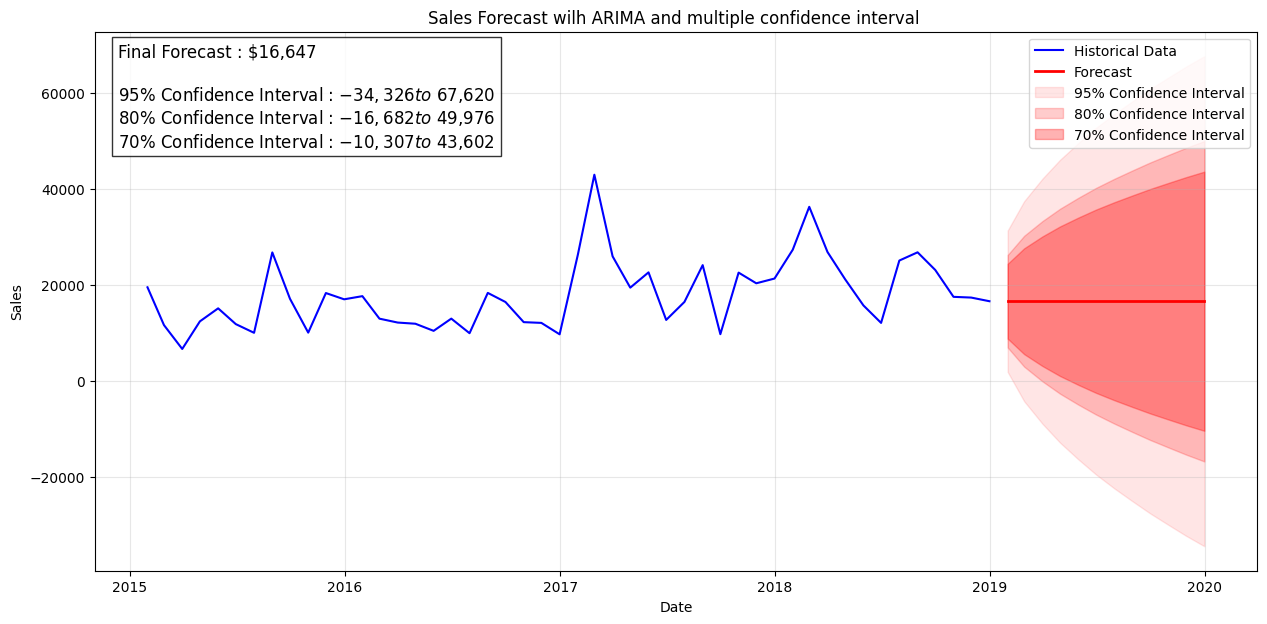

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(monthly_sales, label='Historical Data',color='blue')
plt.plot(mean_forecast, label='Forecast', color='red',linewidth=2)

plt.fill_between(mean_forecast.index,
                 conf_int_95.iloc[:, 0],  # ขอบเขตล่าง
                 conf_int_95.iloc[:, 1],  # ขอบเขตบน
                 color='red', alpha=0.1,
                 label='95% Confidence Interval')

plt.fill_between(mean_forecast.index,
                 conf_int_80.iloc[:, 0],
                 conf_int_80.iloc[:, 1],
                 color='red',
                 alpha=0.2,
                 label='80% Confidence Interval')
plt.fill_between(mean_forecast .index,
                 conf_int_70.iloc[:, 0],
                 conf_int_70.iloc[:, 1],
                 color='red',
                 alpha=0.3,
                 label='70% Confidence Interval')

plt.title('Sales Forecast wilh ARIMA and multiple confidence interval ')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True ,alpha=0.3)

last_forecast_date = mean_forecast.iloc[-1]
ranges_95_lower = conf_int_95.iloc[-1, 0]
ranges_95_upper = conf_int_95.iloc[-1, 1]
ranges_80_lower = conf_int_80.iloc[-1, 0]
ranges_80_upper = conf_int_80.iloc[-1, 1]
ranges_70_lower = conf_int_70.iloc[-1, 0]
ranges_70_upper = conf_int_70.iloc[-1, 1]

into_text = f'Final Forecast : ${last_forecast_date:,.0f}\n\n' \
                f'95% Confidence Interval : ${ranges_95_lower:,.0f} to $ {ranges_95_upper:,.0f}\n' \
                f'80% Confidence Interval : ${ranges_80_lower:,.0f} to $ {ranges_80_upper:,.0f}\n' \
                f'70% Confidence Interval : ${ranges_70_lower:,.0f} to $ {ranges_70_upper:,.0f}'
plt.text(0.02,0.98,into_text,
         transform=plt.gca().transAxes,
         fontsize=12,verticalalignment='top',bbox=dict(facecolor='white',alpha=0.8))
plt.show()

### ประเมินผลแบบจำลอง
- ขออธิบายแยกเป็นส่วนๆ
- Mean Squared Error (MSE): คำนวณค่าเฉลี่ยของกำลังสองของความแตกต่างระหว่างค่าจริงและค่าทำนาย
- Root Mean Squared Error (RMSE): คำนวณรากที่สองของ MSE
- Mean Absolute Error (MAE): คำนวณค่าเฉลี่ยของค่าสัมบูรณ์ของความแตกต่างระหว่างค่าจริงและค่าทำนาย


In [ ]:
print("\nModel Parameters Metrics:")
mse = mean_squared_error(monthly_sales, results.fittedvalues)
rmse = np.sqrt(mse)
mae = mean_absolute_error(monthly_sales, results.fittedvalues)

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")

print("\nForecast Ranges for Final Period:")
print(f"Point Forecast: ${last_forecast_date:,.2f}")
print("\nConfidence Intervals:")
print(f"95% Confidence Interval: ${ranges_95_lower:,.2f} to $ {ranges_95_upper:,.2f}")
print(f"80% Confidence Interval: ${ranges_80_lower:,.2f} to $ {ranges_80_upper:,.2f}")
print(f"70% Confidence Interval: ${ranges_70_lower:,.2f} to $ {ranges_70_upper:,.2f}")

print("\nInteval Widths as Percentage of Forecast:")
print(f"95% Confidence Interval: ±{((ranges_95_upper - ranges_95_lower) /2/ last_forecast_date*100):.1f}%")
print(f"80% Confidence Interval: ±{((ranges_80_upper - ranges_80_lower) /2/ last_forecast_date*100):.1f}%")
print(f"70% Confidence Interval: ±{((ranges_70_upper - ranges_70_lower) /2/ last_forecast_date*100):.1f}%")

forecast_df = pd.DataFrame({
    'Forecast': mean_forecast,
    'Lower_95': conf_int_95.iloc[:, 0],
    'Upper_95': conf_int_95.iloc[:, 1],
    'Lower_80': conf_int_80.iloc[:, 0],
    'Upper_80': conf_int_80.iloc[:, 1],
    'Lower_70': conf_int_70.iloc[:, 0],
    'Upper_70': conf_int_70.iloc[:, 1]
})
print("\nDetailed Forecast with Confidence Interval:")
print(forecast_df)


Model Parameters Metrics:
Mean Squared Error (MSE): 64323166.75
Root Mean Squared Error (RMSE): 8020.17
Mean Absolute Error (MAE): 6141.84

Forecast Ranges for Final Period:
Point Forecast: $16,647.04

Confidence Intervals:
95% Confidence Interval: $-34,325.77 to $ 67,619.86
80% Confidence Interval: $-16,682.29 to $ 49,976.37
70% Confidence Interval: $-10,307.50 to $ 43,601.58

Inteval Widths as Percentage of Forecast:
95% Confidence Interval: ±306.2%
80% Confidence Interval: ±200.2%
70% Confidence Interval: ±161.9%

Detailed Forecast with Confidence Interval:
            Forecast   Lower_95  Upper_95   Lower_80  Upper_80   Lower_70  \
2019-01-31 16,647.04   1,932.46 31,361.63   7,025.69 26,268.39   8,865.94   
2019-02-28 16,647.04  -4,162.52 37,456.61   3,040.40 30,253.68   5,642.90   
2019-03-31 16,647.04  -8,839.37 42,133.45     -17.62 33,311.71   3,169.77   
2019-04-30 16,647.04 -12,782.13 46,076.21  -2,595.66 35,889.74   1,084.83   
2019-05-31 16,647.04 -16,255.77 49,549.85  -4,8

# การทำนายแบบ Exponential Smoothing หลายๆ แบบ
- เพื่อนำไปใช้ในการพยากรณ์ข้อมูลอนุกรมเวลา (time series data) โดยเฉพาะข้อมูลที่อาจมีฤดูกาล (seasonal) หรือแนวโน้ม (trend)

In [ ]:
model = []
Specifications = [
    {'name':'Fixed Parameters',
     'model': ExponentialSmoothing(
         monthly_sales,
         seasonal_periods=12,
         trend='add',
         seasonal='add',
         damped_trend=True
    ).fit(
        smoothing_level=0.2,
        smoothing_trend=0.1,
        smoothing_seasonal=0.1,
        damping_trend=0.98,
        optimized=False
    )
},
{    'name': 'Multiplicative Seasonal',
     'model': ExponentialSmoothing(
         monthly_sales,
         seasonal_periods=12,
         trend='add',
         seasonal='mul',
         damped_trend=True
     ).fit(
         smoothing_level=0.2,
         smoothing_trend=0.1,
         smoothing_seasonal=0.1,
         damping_trend=0.98,
         optimized=False
    )
},
{    'name': 'Multiplicative Trend',
     'model': ExponentialSmoothing(
         monthly_sales,
         seasonal_periods=12,
         trend='mul',
         seasonal='add',
         damped_trend=True
     ).fit(
         smoothing_level=0.2,
         smoothing_trend=0.1,
         smoothing_seasonal=0.1,
         damping_trend=0.98,
         optimized=False
         )
    }
]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


# ประเมินความแม่นยำของแบบจำลอง Exponential Smoothing ส่วนที่ 1

In [ ]:
results = []
for spec in Specifications:
    model = spec['model']
    name = spec['name']
rmse = np.sqrt(mean_squared_error(monthly_sales, model.fittedvalues))
mae = mean_absolute_error(monthly_sales, model.fittedvalues)
results.append({
    'name': name,
    'rmse': rmse,
    'mae': mae,
    'model':model
})

## เลือกแบบจำลองที่ทำนายได้แม่นยำที่สุด

In [ ]:
best_model = min(results, key=lambda x: x['rmse'])
hw_model = best_model['model']
hw_forecast = hw_model.forecast(12)

### วิเคราะห์กราฟผลการทำนาย
- แบบจำลอง "Multiplicative Trend" เป็นแบบจำลองที่ดีที่สุด จากตัวเลือกที่มี
- เพราะเส้นกราฟของผลการทำนาย (เส้นสีฟ้าอ่อน) ซ้อนทับกับข้อมูลจริง (เส้นสีน้ำเงินเข้ม) ได้ค่อนข้างดีในช่วงเวลาที่เป็นข้อมูลจริง หมายความว่าแบบจำลองสามารถจับแนวโน้มและฤดูกาลของข้อมูลได้ค่อนข้างดี
- กราฟทำนายในอนาคต (เส้นสีเขียวประ) มีแนวโน้มที่สอดคล้องกับข้อมูลในอดีต แสดงให้เห็นว่าแบบจำลองสามารถทำนายค่าในอนาคตได้ค่อนข้างน่าเชื่อถือ
- ทั้งนี้ แบบจำลอง "Multiplicative Trend" เป็นเพียงแบบจำลองเท่านั้น
- ยังมีปัจจัยหลายอย่างที่ส่งผลกระทบต่อ รายได้ของบริษัท

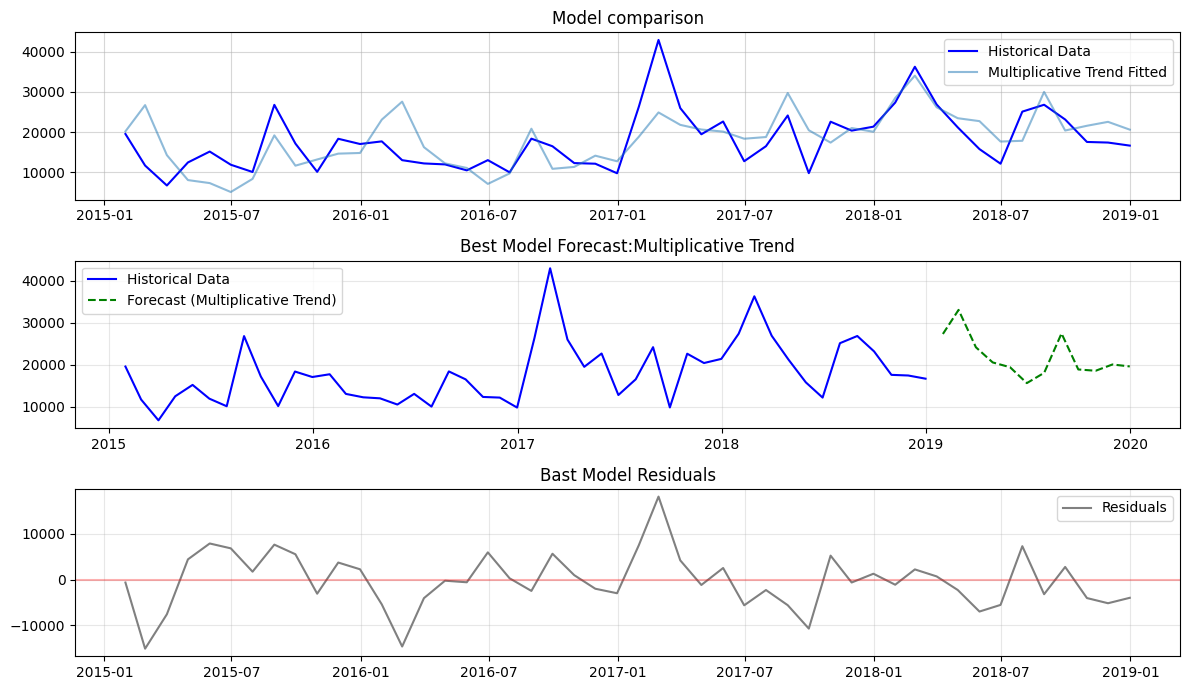

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(3, 1, 1)
plt.plot(monthly_sales.index, monthly_sales, label='Historical Data', color='blue')
for result in results:
    plt.plot(result['model'].fittedvalues.index,
             result['model'].fittedvalues,
             label=f"{result['name']} Fitted",
             alpha=0.5)
plt.title('Model comparison')
plt.legend()
plt.grid(True, alpha=0.5)

plt.subplot(3, 1, 2)
plt.plot(monthly_sales.index, monthly_sales, label='Historical Data', color='blue')
plt.plot(hw_forecast.index,hw_forecast,
         label=f'Forecast ({best_model["name"]})',
         color='green',linestyle='--')

plt.title(f'Best Model Forecast:{best_model["name"]}')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
residuals = monthly_sales - hw_model.fittedvalues
plt.plot(monthly_sales.index, residuals, label='Residuals', color='gray')
plt.axhline(y=0, color='red', linestyle='-',alpha=0.3)
plt.title('Bast Model Residuals')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## แบบจำลองแต่ละแบบที่เราสร้างขึ้นมานั้น ทำนายค่าได้แม่นยำแค่ไหน
- เป้าหมายของการวิเคราะห์: คือการหาแบบจำลองที่ดีที่สุด ที่สามารถทำนายค่าในอนาคตได้อย่างแม่นยำ
## สรุป
ผลการเปรียบเทียบนี้ชี้ให้เห็นว่าโมเดลที่ใช้แนวคิด Multiplicative Trend เหมาะสมกับข้อมูลชุดนี้มากที่สุด และสามารถนำไปใช้ในการพยากรณ์ค่าในอนาคตได้ อย่างไรก็ตาม ควรพิจารณาปัจจัยอื่นๆ ร่วมด้วย
- RMSE และ MAE ที่สูงบ่งชี้ว่าโมเดลอาจมีความคลาดเคลื่อนในการทำนายค่อนข้างมาก

In [ ]:
print("\nModel comparison:")
for result in results:
    print(f"\n{result['name']}:")
    print(f"RMSE: ${result['rmse']:.2f}")
    print(f"MAE: ${result['mae']:.2f}")

print(f"\nBest Model:{best_model['name']}")
print(f"RMSE: {best_model['rmse']:.2f}")
print(f"MAE: {best_model['mae']:.2f}")


Model comparison:

Multiplicative Trend:
RMSE: $5976.21
MAE: $4606.12

Best Model:Multiplicative Trend
RMSE: 5976.21
MAE: 4606.12


In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# คำอธิบายค่าสำคัญๆ
- Dep. Variable: Sales: หมายถึงตัวแปรที่เราต้องการทำนาย ซึ่งในที่นี้คือ "ยอดขาย"
- No. Observations: 48: หมายถึงจำนวนข้อมูลทั้งหมดที่นำมาใช้ในการสร้างแบบจำลอง
- Model: ExponentialSmoothing: ระบุว่าแบบจำลองที่ใช้คือ Exponential Smoothing
- Trend: Multiplicative: แสดงให้เห็นว่าแบบจำลองนี้พิจารณาถึงแนวโน้ม (Trend)
ของข้อมูลในลักษณะที่คูณเข้ากับส่วนประกอบอื่นๆ
- Seasonal: Additive: แสดงให้เห็นว่าแบบจำลองนี้พิจารณาถึงฤดูกาล (Seasonality) ของข้อมูลในลักษณะที่บวกเข้ากับส่วนประกอบอื่นๆ
- Seasonal Periods: 12: หมายถึงจำนวนช่วงเวลาในหนึ่งฤดูกาล (เช่น 12 เดือน)
- smoothing_level, smoothing_trend, smoothing_seasonal: ค่าเหล่านี้เป็นพารามิเตอร์ที่ใช้ในการปรับน้ำหนักของข้อมูลในอดีตในการทำนายอนาคต ค่าที่สูงขึ้นจะให้ความสำคัญกับข้อมูลล่าสุดมากขึ้น
- initial_level, initial_trend, initial_seasons: ค่าเริ่มต้นที่ใช้ในการคำนวณแบบจำลอง
- AIC, BIC, AICC: เป็นค่าสถิติที่ใช้ในการเปรียบเทียบแบบจำลองต่างๆ โดยทั่วไปค่าที่ต่ำกว่าแสดงว่าแบบจำลองนั้นดีกว่า

In [ ]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:                    Sales   No. Observations:                   48
Model:             ExponentialSmoothing   SSE                     1714325920.643
Optimized:                        False   AIC                            868.772
Trend:                   Multiplicative   BIC                            900.582
Seasonal:                      Additive   AICC                           895.915
Seasonal Periods:                    12   Date:                 Sat, 30 Nov 2024
Box-Cox:                          False   Time:                         03:32:28
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.2000000                alpha                False
smoothing_trend               0.1000000                 beta                False
smoothing_seasonal            0.1000000                gamma                False
initial_level                 15065.416                  l.0                False
initial_trend                 0.9952682                  b.0                False
damping_trend                 0.9800000                  phi                False
initial_seasons.0             5205.2142                  s.0                False
initial_seasons.1             11949.487                  s.1                False
initial_seasons.2             2799.4270                  s.2                False
initial_seasons.3            -1531.5720                  s.3                False
initial_seasons.4            -2866.0505                  s.4                False
initial_seasons.5            -6509.6817                  s.5                False
initial_seasons.6            -4581.1610                  s.6                False
initial_seasons.7             5889.6102                  s.7                False
initial_seasons.8            -3365.0047                  s.8                False
initial_seasons.9            -3242.6138                  s.9                False
initial_seasons.10           -1418.7140                 s.10                False
initial_seasons.11           -2328.9408                 s.11                False
---------------------------------------------------------------------------------
"""

### Prescriptive Analytics (การวิเคราะห์เชิงกำหนด)
- จะทำอะไรเพื่อให้ได้ผลลัพธ์ที่ดีที่สุด
- จุดประสงค์คือการเพิ่มยอดขายให้กับบริษัท
## Insight ของข้อมูลที่ได้มา
1. ลูกค้า Segment ไหนที่ในภาพรวมแล้วใช้จ่ายกับเรามากที่สุด
- ลูกค้า Consumer ใช้จ่ายกับเรามากที่สุด
- ลูกค้า Corporate เป็นกลุ่มที่ใช้จ่ายรองลงมาเป็นอันดับ 2
- กลุ่มลูกค้า Home office ใช้จ่ายกับเราน้อยที่สุด
----
2. กลุ่มลูกค้า Consumer ไม่ได้นิยมชื้อสินค้า Technology แต่เป็นสินค้า Category ประเภท Office Supplies มากกว่า
- แต่สิ่งที่ทำให้บริษัทมียอดขายเพิ่ม คือสินค้าประเภท Techonlogy ที่อาจจะเป็นเพียงแค่กระแส ในปี 2017 - 2018
- เพราะสินค้าที่มีความนิยมอาจจะไม่ใช่สินค้าราคาสูง อาจจะเป็นสินค้านิยมใช้ในชีวิตประจำวัน เช่น Office Supplies
- สรุปสินค้าที่เป็นที่นิยมของกลุ่มลูกค้า คือ Office Supplies ไม่ใช้ Technology
- สินค้า Technology เป็นเพียงสินค้าราคาสูง อาจจะเป็นกระแสได้ความนิยม แต่อาจจะยังไม่ใช่สินต้ายอดนิยม Consumer
3.  ยอดขายมากจากทาง ทิศตะวันออก มากที่สุด
- รองลงมาก็มากจาก ตะวันตก
- คาดว่ากลุ่มลูกค้าน่าจะเป็นคนทาง ทิศตะวันออก และ ตะวันตก ที่มาใช้บริการสินค้า
- จากข้อมูลที่ได้พบว่า ทิศตะวันออก ตะวันตกขายสินค้าเทคโนโลยีได้มากที่สุด
- ลูกค้าภาคกลาง และ ภาคใต้ ยังอยู่ในระดับที่น้อยกว่า ทิศตะวันออก ตะวันตก ดังนั้นเราควรจะมาทำการตลาด เพื่อเพิ่มยอดขายให้กับ Central และ South 2 ภาคนี้จะดีกว่า
----
4.  จากที่พบ ภาค West East เป็นภาคที่สามารถขายสินค้าได้ทั้ง 3 หมวดได้ ค่อนข้างจะเยอะ เพราะยอดขายของทั้ง 3 หมวดนั้นมียอดขายที่ใกล้เคียงกันมาก
----
5.  จากข้อมูลพบว่า สินค้าเทคโนโลยีนั้นลูกค้าของเราจะอยู่ที่รัฐ California เป็นหลัก เพราะ ติด top มาก 2 เมือง คือ los Angeles และ San Francisco
- ที่นิยมชื้อของที่เป็นเทคโนโลยีไป โดนสินค้าที่เป็นที่นิยมมากที่สุดก็คือ Phones
----
6. สินค้า Technology ใช้เวลาขายสินค้า 322 วัน
7.  สินค้า Office Supplies ใช้เวลาขายสินค้า 443 วัน (ประมาณ 1 ปี กับอีก 5 เดือน โดยประมาณ)
8.  Furniture ใช้เวลาขายสินค้า 335 วัน หรือ ไม่ถึง 1 ปี
- ในปี 2015 สินค้า Furniture เป็นสินค้าที่ทำยอดขายได้มากที่สุด
- ในปี 2016 สินค้า Technology เริ่มที่จะเป็นสินค้าที่ทำยอดขายได้มากที่สุด ตั้งแต่ 2016 ถึง 2018 ทั้งๆที่ภาพรวมปี 2016 มียอดขายน้อยกว่า ปี 2015

### จาก Insight ที่ได้รับมา สามารถทำ Prescriptive Analytics (การวิเคราะห์เชิงกำหนด) ได้ดังนี้
- เราควรจะรักษากลุ่มลูกค้า Consumer ที่มากจาทาง West East เอาไว้ก่อน
- โดยเราจะทำการเก็บข้อมูลเพิ่มเติม เช่น เก็บข้อมูลยอดขายประจำวัน และปัจจัยภายนอก เช่น วันหยุด, เทศกาล เพศ เพื่อให้ได้ข้อมูลเชิงลึกมากขึ้น
- ลูกค้าภาคกลาง และ ภาคใต้ ยังอยู่ในระดับที่น้อยกว่า ทิศตะวันออก ตะวันตก ดังนั้นเราควรจะมาทำการตลาด เพื่อเพิ่มยอดขายให้กับ Central และ South 2 ภาคนี้จะดีกว่า โดยการเก็บข้อมูล เก็บข้อมูลยอดขายประจำวัน และปัจจัยภายนอก เช่น วันหยุด, เทศกาล เพศ เพื่อให้ได้ข้อมูลเชิงลึกมากขึ้น และทำ CRM เพิ่มเติม
- ลูกค้าที่อยู่รัฐ 5 รัฐ ตามข้อมูล โดนเฉพาะ California 2 เมือง คือ los Angeles และ San Francisco ควรจะสร้างความสัมพันธ์ด้วย CRM เพื่อให้ลูกค้าคิดถึง บริษัทของเรา
- สินค้า Office Supplies ที่ใช้เวลาขายสินค้า 443 วัน (ประมาณ 1 ปี กับอีก 5 เดือน โดยประมาณ) ควรเข้าไปตรวจสล็อกเพื่อดูว่า สินค้าตัวไหนขายได้ช้า ควรจะรับเอามาจัดโปรโมชั่น เพื่อให้สินค้าออกจากสต็อกไป โดยอาจจะให้ส่วนลด เมื่อชื้อคู่ เหมือนกัยการทำ Market Basket Analysis เพื่อให้ลูกค้าชื้อของในลักษณะคู่ เช่น Binders ชื้อคู่กับ Paper ได้ส่วนลด 10 %
- ส่วนสินค้าไหนที่ขายได้อยู่แล้วไม่ต้องจัดโปรโมชั่น
- เก็บข้อมูลลูกค้าใหม่เพิ่มขึ้น เน้นที่ Central และ South 2 ภาคนี้
- เน้นการเพิ่มยอดขายผ่านช่องทางออนไลน์มากขึ้น ประกอบกับทำ CRM เน้นเป็นกลยุทธ์หลัก เพื่อสร้างความสัมพันธ์กับลูกค้า

----

## วิเคราะห์ข้อมูล outliers เพื่อหาข้อมูลเพิ่มเติม

In [ ]:
aunlysis_outliner = pd.read_csv('/content/outliers_sales.csv')
aunlysis_outliner

Row ID        Order ID  Order Date   Ship Date       Ship Mode  \
0          2  CA-2017-152156  2017-08-11  11/11/2017    Second Class   
1          4  US-2016-108966  2016-11-10  18/10/2016  Standard Class   
2          8  CA-2015-115812  2015-09-06  14/06/2015  Standard Class   
3         11  CA-2015-115812  2015-09-06  14/06/2015  Standard Class   
4         12  CA-2015-115812  2015-09-06  14/06/2015  Standard Class   
...      ...             ...         ...         ...             ...   
1136    9760  CA-2017-146913         NaN  05/11/2017  Standard Class   
1137    9775  CA-2015-169019         NaN  30/07/2015  Standard Class   
1138    9782  CA-2017-153178         NaN  18/09/2017  Standard Class   
1139    9788  CA-2018-144491         NaN  01/04/2018  Standard Class   
1140    9789  CA-2018-144491         NaN  01/04/2018  Standard Class   

     Customer ID    Customer Name    Segment        Country             City  \
0       CG-12520      Claire Gute   Consumer  United States        Henderson   
1       SO-20335   Sean O'Donnell   Consumer  United States  Fort Lauderdale   
2       BH-11710  Brosina Hoffman   Consumer  United States      Los Angeles   
3       BH-11710  Brosina Hoffman   Consumer  United States      Los Angeles   
4       BH-11710  Brosina Hoffman   Consumer  United States      Los Angeles   
...          ...              ...        ...            ...              ...   
1136    SF-20965  Sylvia Foulston  Corporate  United States    San Francisco   
1137    LF-17185      Luke Foster   Consumer  United States      San Antonio   
1138    CL-12565      Clay Ludtke   Consumer  United States       Long Beach   
1139    CJ-12010  Caroline Jumper   Consumer  United States          Houston   
1140    CJ-12010  Caroline Jumper   Consumer  United States          Houston   

           State  Postal Code   Region       Product ID         Category  \
0       Kentucky    42,420.00    South  FUR-CH-10000454        Furniture   
1        Florida    33,311.00    South  FUR-TA-10000577        Furniture   
2     California    90,032.00     West  TEC-PH-10002275       Technology   
3     California    90,032.00     West  FUR-TA-10001539        Furniture   
4     California    90,032.00     West  TEC-PH-10002033       Technology   
...          ...          ...      ...              ...              ...   
1136  California    94,109.00     West  FUR-CH-10001854        Furniture   
1137       Texas    78,207.00  Central  OFF-BI-10004995  Office Supplies   
1138    New York    11,561.00     East  OFF-BI-10004390  Office Supplies   
1139       Texas    77,070.00  Central  FUR-BO-10001811        Furniture   
1140       Texas    77,070.00  Central  FUR-CH-10004063        Furniture   

     Sub-Category                                       Product Name    Sales  
0          Chairs  Hon Deluxe Fabric Upholstered Stacking Chairs,...   731.94  
1          Tables      Bretford CR4500 Series Slim Rectangular Table   957.58  
2          Phones                     Mitel 5320 IP Phone VoIP phone   907.15  
3          Tables           Chromcraft Rectangular Conference Tables 1,706.18  
4          Phones      Konftel 250 Conference phone - Charcoal black   911.42  
...           ...                                                ...      ...  
1136       Chairs  Office Star - Professional Matrix Back Chair w... 1,403.92  
1137      Binders          GBC DocuBind P400 Electric Binding System 2,177.58  
1138      Binders            GBC DocuBind 200 Manual Binding Machine   673.57  
1139    Bookcases  Atlantic Metals Mobile 5-Shelf Bookcases, Cust... 1,023.33  
1140       Chairs            Global Deluxe High-Back Manager's Chair   600.56  

[1141 rows x 18 columns]

In [ ]:
aunlysis_outliner.describe()

Row ID  Postal Code     Sales
count 1,141.00     1,141.00  1,141.00
mean  4,769.08    54,080.14  1,267.97
std   2,810.02    32,638.90  1,427.28
min       2.00     1,841.00    500.24
25%   2,417.00    21,215.00    636.41
50%   4,671.00    53,209.00    868.59
75%   7,244.00    90,008.00  1,347.52
max   9,789.00    99,301.00 22,638.48

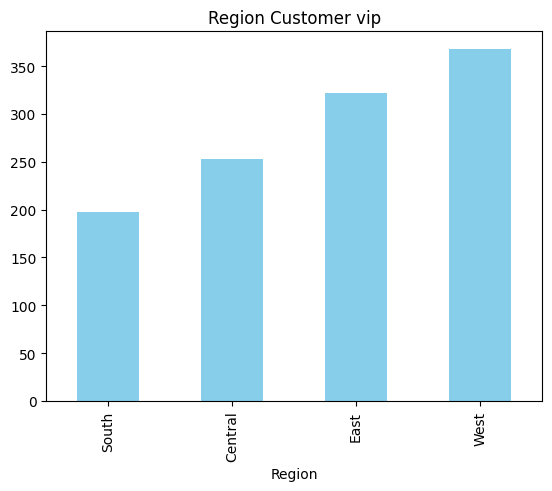

In [ ]:
aunlysis_outliner.value_counts('Region').sort_values(ascending=True).plot(kind='bar',color='skyblue',y='population',
                                                           title='Region Customer vip');

### ข้อมูลเพื่อเติม
- กลุ่มลูกค้า outliner ได้นิยมชื้อของคือ Technology
- มีค่าเฉลี่ยอยู่ที่คนละประมาณ 1500


sum  median     mean
Category                                   
Technology      600,748.94  899.98 1,528.62
Furniture       480,668.28  853.93 1,049.49
Office Supplies 365,336.35  870.19 1,259.78

<Axes: title={'center': 'Top category vip'}, xlabel='Category'>

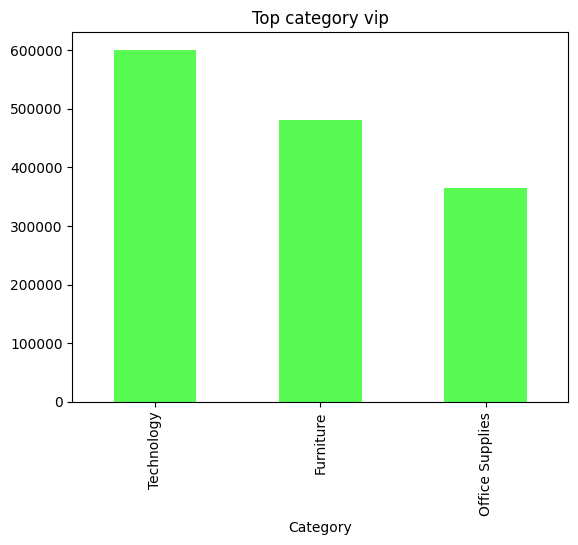

In [ ]:
display(aunlysis_outliner.groupby('Category')['Sales'].agg(['sum','median','mean']).sort_values(by='sum',ascending=False),
        aunlysis_outliner.groupby('Category')['Sales'].sum().sort_values(ascending=False).plot(kind='bar',color='#58fb52',title='Top category vip'));

### เมืองที่ลูกค้าอาคัยอยู่ และพอจะมีกำลังชื้อ 10 เมือง
- 10 เมืองนี้เราควรจะทำการตลาด เพื่อเพิ่มยอดขายให่กับบริษัท
- 10 เมืองนี้ลูกค้าพอจะมีกำลังชื้อ
- Seattle median มากกว่าที่อื่น
- Jacksonville ที่มีค่าเฉลี่ยสูง

In [ ]:
aunlysis_outliner.groupby('City')['Sales'].agg(['sum','median','mean']).sort_values(by='sum',ascending=False)[0:10]

sum   median     mean
City                                      
New York City 178,299.18   900.08 1,449.59
Los Angeles   107,795.75   892.35 1,159.09
Seattle        81,325.13 1,000.02 1,426.76
San Francisco  72,159.21   863.13 1,265.95
Philadelphia   67,474.56   791.96 1,226.81
Houston        38,678.61   896.99 1,045.37
Jacksonville   37,242.68   939.15 2,660.19
San Diego      33,076.66   774.84 1,102.56
Springfield    29,326.72   838.38 1,396.51
Chicago        27,824.54   781.78   993.73

### เมืองที่น่าสนใจคือ
- Seattle กับ Jacksonville
- Seattle เป็นเมืองที่ขายสินค้าทั้ง 3 Category ได้ค่อนข้างมากกว่า Jacksonville
- Jacksonville มีส่วนค่าเฉลี่ยที่โดดเด่น อยู่ในหมวด Technology โดยสามารถอนุมาณได้ประมาณนึงว่า Jacksonville อาจจะมีกลุ่มลูกค้าที่มีกำลังชื้อซ่อนอยู่ในนั้น ต้องตรวจสอบประชากร เมือง Jacksonville ให้ดี ว่ามีเท่าไร
### สรุป สิ่งที่ได้จากการ วิเคราะห์ outliner
- Seattle กับ Jacksonville
- แต่เมือง Seattle น่าสนใจกว่าตรงที่ สามารถชายสินค้าประเภท Furniture และ Office Supplies ได้มากกว่า Jacksonville
- ถ้าจะให้เลือก เมืองที่พอจะมีศักยภาพพอที่จะมาเพิ่มยอดขายได่ก็คงเป็นเมือง Seattle ที่มีความเป็นไปได้มากกว่า jacksonville ที่เด่นแต่สินค้า Technology สินค้าอื่นกลับขายได้น้อยกว่า
### สิ่งนี้ควรจะเก็บข้อมูล 2 เมืองนี้เพิ่มเติม
- เป็นแค่สิ่งที่ผู้วิเคราะห์ สันนิษฐาน และวิเคราะห์เพิ่มเติมขึ้นมากเท่านั้น

In [ ]:
display(aunlysis_outliner[aunlysis_outliner['City']=='Seattle'].groupby('Category')['Sales'].agg(['sum','median','mean']).sort_values(by='sum',ascending=False),
        aunlysis_outliner[aunlysis_outliner['City']=='Jacksonville'].groupby('Category')['Sales'].agg(['sum','median','mean']).sort_values(by='sum',ascending=False))

sum   median     mean
Category                                   
Technology      32,860.63 1,001.58 1,932.98
Furniture       27,328.07   882.19 1,138.67
Office Supplies 21,136.44 1,060.77 1,321.03

sum   median     mean
Category                                   
Technology      26,560.44   822.63 4,426.74
Furniture        6,571.01   945.04 1,314.20
Office Supplies  4,111.23 1,347.52 1,370.41